# Unsupervised Spectral Unmixing with Autoencoders

By Joshua C. Agar, Shuyu Qin

* There are many times where you want to extract imporant features from high-dimensional data
* In essence, the goal is to compress data to some lower latent space where you can extract information

![](figs/3-swissroll-unfolded.png)

# Autoencoder

![imag](figs/Autoencoder.png)

* **Encoder** - Neural network that deconstructs the data into the most important statistical components
* **Embedding Layer(s)** - One or many layers were information is extracted
* **Decoder** - Neural network that translates the latent space to original dimensionality. 



## Mathematical Objective
* Minimize the reconstruction loss based on some metric. 
  * Mean squared error

  Good at avoiding influence of anomalies
  * Mean absolute error

  Good at capturing details within spectra



## Optimizers
* Standard optimizers like ADAM tend to be sufficient
* Can use more complex optimizers 2nd order, adhessian to optimize small models. 



## Practical Objective
* Create an autoencoder that has performant reconstruction
* Create a low-dimensional and interpretable latent space
  * Reduce the dimensionality
  * Impose non-negativity contraints
  * Impose regularization
  * Impose sparsity
  * Impose constraints on the shape of the latent distribution
  * Impose soft-constraints that favor disentanglement
* Create a latent trajectory that is suitable for generation 

# Imports Packages

In [19]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import copy

# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torch
from tqdm import tqdm
import os

from torchsummary import summary

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

from m3_learning.util.data_generators import generate_data
from m3_learning.viz.layout import layout_fig, embedding_maps, latent_generator
from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn


# Generating Data
* We want to generate a hyperspectral image
* This can be done by taking the RGB values of an image and using them as parameters for a function

## Loads and image of my dog Nala
* Painting by *Irene Dogmatic*

In [3]:
# Loads dog image
image = io.imread("./figs/nala.jpg")

# Crops dog image
image = image[200:1900:20, 100:1500:20] / 255


## Displays the image

In [4]:
plt.imshow(image)


## Generating some data based on the image
### Define a non-linear function

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/generated.png?raw=true)

In [5]:
def non_linear_fn(t, x, y, z):
    tanh = nn.Tanh()
    selu = nn.SELU()
    sigmoid = nn.Sigmoid()

    # returns a function from variables
    return (
        tanh(torch.tensor(20 * (t - 2 * (x - 0.5))))
        + selu(torch.tensor((t - 2 * (y - 0.5))))
        + sigmoid(torch.tensor(-20 * (t - (z - 0.5))))
    )


In [6]:
# generates a hyperspectral image
dog_data = generate_data(image.reshape(-1, 3), length=10, function=non_linear_fn)


In [7]:
# Conducts a test train split.
# because we are training an autoencoder x and y are the same
X_train, X_test, _, _ = train_test_split(
    dog_data, dog_data, test_size=0.2, random_state=42
)


## Plots the generated data

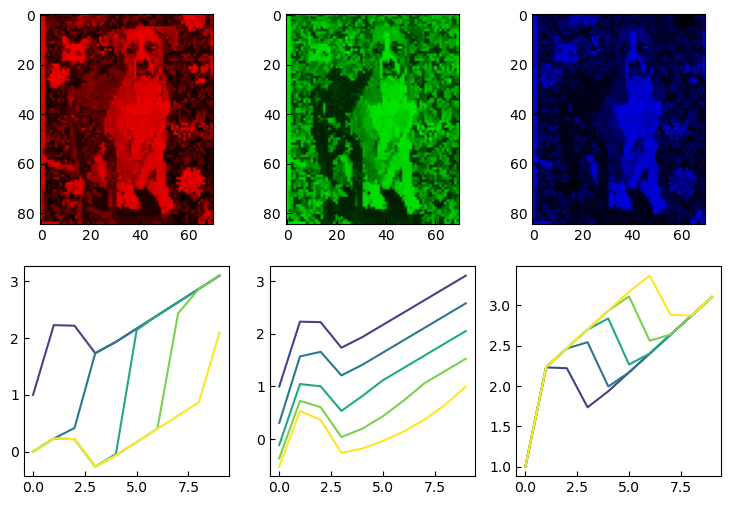

In [8]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)


# Let's Build a Simple Autoencoder

## Defines the encoder and the decoder

In [9]:
latent_dim = 12


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.dense_1 = nn.Linear(10, self.latent_dim)

    def forward(self, x):
        # single dense layer in the model
        x = self.dense_1(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.dense_1 = nn.Linear(self.latent_dim, 10)

    def forward(self, x):
        # single dense layer in the decoder
        x = self.dense_1(x)
        return x


## Builds the autoencoder

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        # encode
        embedding = self.encoder(x)
        # decode
        predicted = self.decoder(embedding)

        return predicted


# Instantiates the model

In [11]:
import cpuinfo
cpudata = cpuinfo.get_cpu_info()['brand_raw']
cpuname = cpudata.split(" ")[1]

if cpuname == 'M1':
    device = "mps"
elif torch.cuda.device_count():
    device = "cuda"
else: 
    device = "cpu"

print(f'You are running on a {device}')

device = 'cpu'

encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


You are running on a mps


In [12]:
try: 
    summary(model, ((X_train.shape[1:])))
except:
    model_cpu = copy.deepcopy(model).to('cpu')
    summary(model_cpu, ((X_train.shape[1:])))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]             132
           Encoder-2                   [-1, 12]               0
            Linear-3                   [-1, 10]             130
           Decoder-4                   [-1, 10]               0
Total params: 262
Trainable params: 262
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


* Encoder with 12 latent dimensions
* Decoder with with size 10 --> same as orignal spectral length
* Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample

In [13]:
train_iterator = torch.utils.data.DataLoader(X_train, batch_size=256, shuffle=True)


In [ ]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device = device)


In [15]:
encode, decode = transform_nn(dog_data, encoder, decoder, device = device)


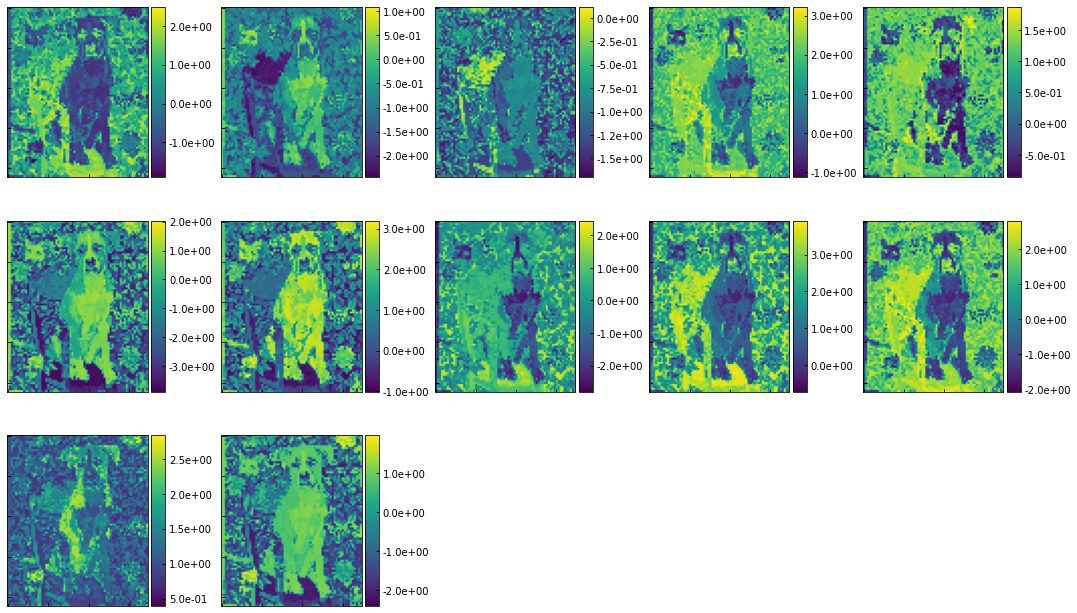

In [19]:
embedding_maps(encode, image)


* This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables

## We know that we only have 3 intrinsic latent variables

# Instantiates the model

In [20]:
device = "cuda"

encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [21]:
summary(model, ((X_train.shape[1:])))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]              33
           Encoder-2                    [-1, 3]               0
            Linear-3                   [-1, 10]              40
           Decoder-4                   [-1, 10]               0
Total params: 73
Trainable params: 73
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


* Encoder with 3 latent dimensions
* Decoder with with size 10 --> same as orignal spectral length
* Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample

In [22]:
train_iterator = torch.utils.data.DataLoader(X_train, batch_size=256, shuffle=True)


In [ ]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device = device)


In [18]:
encode, decode = transform_nn(dog_data, encoder, decoder, device = device)


: 

: 

In [17]:
embedding_maps(encode, image)


* This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables

# Generator
* Now we want to see how the spectra changes as we traverse the latent space

In [21]:
latent_generator(decoder, encode, image, 5, 10, device = device)


# Recurrent Neural Network Autoencoders
* The above example did not consider the temporal information in the data. 
* This can be improved by using a recurrent neural network that processes each time step sequentially.
* To add an understanding about the short and long term information in the data you can add memory and forget logic as a learnable parameter.

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/Autoencoder_Med.png?raw=true)

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/LSTM%20Node.png?raw=true)

In [27]:
latent_dim = 12

# input (batch,)
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


# LSTM Autoencoder with 12 latent dimensions

In [28]:
device = "cuda"

encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [29]:
model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [30]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


In [31]:
torch.manual_seed(0)
nn_util.Train(model, encoder, decoder, train_iterator, optimizer, 500)


 47%|████▋     | 9/19 [00:00<00:00, 86.29it/s]

Epoch 0, Train Loss: 2.1977
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.52it/s]

Epoch 1, Train Loss: 2.1896
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.26it/s]

Epoch 2, Train Loss: 2.1816
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 89.08it/s]

Epoch 3, Train Loss: 2.1736
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.63it/s]

Epoch 4, Train Loss: 2.1655
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.31it/s]

Epoch 5, Train Loss: 2.1573
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.74it/s]

Epoch 6, Train Loss: 2.1491
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.19it/s]

Epoch 7, Train Loss: 2.1408
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.70it/s]

Epoch 8, Train Loss: 2.1324
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.92it/s]

Epoch 9, Train Loss: 2.1239
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.46it/s]

Epoch 10, Train Loss: 2.1153
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.35it/s]

Epoch 11, Train Loss: 2.1065
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.14it/s]

Epoch 12, Train Loss: 2.0976
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.86it/s]

Epoch 13, Train Loss: 2.0885
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.06it/s]

Epoch 14, Train Loss: 2.0793
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.56it/s]

Epoch 15, Train Loss: 2.0699
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.82it/s]

Epoch 16, Train Loss: 2.0602
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.76it/s]

Epoch 17, Train Loss: 2.0504
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.79it/s]

Epoch 18, Train Loss: 2.0403
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.61it/s]

Epoch 19, Train Loss: 2.0300
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.07it/s]

Epoch 20, Train Loss: 2.0195
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.12it/s]

Epoch 21, Train Loss: 2.0088
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.81it/s]

Epoch 22, Train Loss: 1.9978
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.20it/s]

Epoch 23, Train Loss: 1.9865
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.69it/s]

Epoch 24, Train Loss: 1.9750
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.03it/s]

Epoch 25, Train Loss: 1.9633
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.30it/s]

Epoch 26, Train Loss: 1.9513
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.07it/s]

Epoch 27, Train Loss: 1.9391
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.66it/s]

Epoch 28, Train Loss: 1.9266
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.36it/s]

Epoch 29, Train Loss: 1.9139
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.77it/s]

Epoch 30, Train Loss: 1.9010
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.83it/s]

Epoch 31, Train Loss: 1.8879
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.44it/s]

Epoch 32, Train Loss: 1.8746
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.38it/s]

Epoch 33, Train Loss: 1.8611
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.32it/s]

Epoch 34, Train Loss: 1.8474
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.72it/s]

Epoch 35, Train Loss: 1.8336
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.93it/s]

Epoch 36, Train Loss: 1.8196
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.29it/s]

Epoch 37, Train Loss: 1.8055
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.51it/s]

Epoch 38, Train Loss: 1.7914
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.60it/s]

Epoch 39, Train Loss: 1.7772
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.59it/s]

Epoch 40, Train Loss: 1.7630
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.97it/s]

Epoch 41, Train Loss: 1.7489
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.19it/s]

Epoch 42, Train Loss: 1.7348
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.11it/s]

Epoch 43, Train Loss: 1.7207
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.72it/s]

Epoch 44, Train Loss: 1.7068
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.37it/s]

Epoch 45, Train Loss: 1.6931
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.19it/s]

Epoch 46, Train Loss: 1.6795
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.96it/s]

Epoch 47, Train Loss: 1.6660
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.11it/s]

Epoch 48, Train Loss: 1.6528
.............................


100%|██████████| 19/19 [00:00<00:00, 97.45it/s]

Epoch 49, Train Loss: 1.6398
.............................



 47%|████▋     | 9/19 [00:00<00:00, 81.22it/s]

Epoch 50, Train Loss: 1.6270
.............................


100%|██████████| 19/19 [00:00<00:00, 98.69it/s]


Epoch 51, Train Loss: 1.6144
.............................
Epoch 52, Train Loss: 1.6020
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.40it/s]

Epoch 53, Train Loss: 1.5897
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.53it/s]

Epoch 54, Train Loss: 1.5777
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.31it/s]

Epoch 55, Train Loss: 1.5658
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.08it/s]

Epoch 56, Train Loss: 1.5541
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.07it/s]

Epoch 57, Train Loss: 1.5426
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.81it/s]

Epoch 58, Train Loss: 1.5311
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.76it/s]

Epoch 59, Train Loss: 1.5198
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.33it/s]

Epoch 60, Train Loss: 1.5086
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.18it/s]

Epoch 61, Train Loss: 1.4974
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.40it/s]

Epoch 62, Train Loss: 1.4863
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.50it/s]

Epoch 63, Train Loss: 1.4753
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.09it/s]

Epoch 64, Train Loss: 1.4643
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.90it/s]

Epoch 65, Train Loss: 1.4534
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.99it/s]

Epoch 66, Train Loss: 1.4424
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.63it/s]

Epoch 67, Train Loss: 1.4315
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.24it/s]

Epoch 68, Train Loss: 1.4205
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.01it/s]

Epoch 69, Train Loss: 1.4095
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.38it/s]

Epoch 70, Train Loss: 1.3984
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.70it/s]

Epoch 71, Train Loss: 1.3873
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.20it/s]

Epoch 72, Train Loss: 1.3762
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.84it/s]

Epoch 73, Train Loss: 1.3649
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.44it/s]

Epoch 74, Train Loss: 1.3535
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.61it/s]

Epoch 75, Train Loss: 1.3420
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.63it/s]

Epoch 76, Train Loss: 1.3304
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.24it/s]

Epoch 77, Train Loss: 1.3187
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.14it/s]

Epoch 78, Train Loss: 1.3068
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.16it/s]

Epoch 79, Train Loss: 1.2947
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.99it/s]

Epoch 80, Train Loss: 1.2825
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.48it/s]

Epoch 81, Train Loss: 1.2700
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.29it/s]

Epoch 82, Train Loss: 1.2575
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.64it/s]

Epoch 83, Train Loss: 1.2447
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.45it/s]

Epoch 84, Train Loss: 1.2317
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.54it/s]

Epoch 85, Train Loss: 1.2185
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.79it/s]

Epoch 86, Train Loss: 1.2052
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.54it/s]

Epoch 87, Train Loss: 1.1916
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.15it/s]

Epoch 88, Train Loss: 1.1779
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.40it/s]

Epoch 89, Train Loss: 1.1640
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.60it/s]

Epoch 90, Train Loss: 1.1498
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.52it/s]

Epoch 91, Train Loss: 1.1356
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.65it/s]

Epoch 92, Train Loss: 1.1211
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.66it/s]

Epoch 93, Train Loss: 1.1065
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.59it/s]

Epoch 94, Train Loss: 1.0918
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.74it/s]

Epoch 95, Train Loss: 1.0770
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.76it/s]

Epoch 96, Train Loss: 1.0620
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.27it/s]

Epoch 97, Train Loss: 1.0470
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.02it/s]

Epoch 98, Train Loss: 1.0319
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.33it/s]

Epoch 99, Train Loss: 1.0168
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.62it/s]

Epoch 100, Train Loss: 1.0017
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.13it/s]

Epoch 101, Train Loss: 0.9866
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.53it/s]

Epoch 102, Train Loss: 0.9716
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.19it/s]

Epoch 103, Train Loss: 0.9566
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.95it/s]

Epoch 104, Train Loss: 0.9418
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.53it/s]

Epoch 105, Train Loss: 0.9270
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.32it/s]

Epoch 106, Train Loss: 0.9124
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.03it/s]

Epoch 107, Train Loss: 0.8980
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.95it/s]

Epoch 108, Train Loss: 0.8838
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.73it/s]

Epoch 109, Train Loss: 0.8698
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.05it/s]

Epoch 110, Train Loss: 0.8560
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.14it/s]

Epoch 111, Train Loss: 0.8425
.............................


100%|██████████| 19/19 [00:00<00:00, 98.41it/s] 


Epoch 112, Train Loss: 0.8292
.............................
Epoch 113, Train Loss: 0.8162
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.54it/s]

Epoch 114, Train Loss: 0.8034
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.65it/s]

Epoch 115, Train Loss: 0.7909
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.85it/s]

Epoch 116, Train Loss: 0.7787
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.89it/s]

Epoch 117, Train Loss: 0.7667
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.48it/s]

Epoch 118, Train Loss: 0.7549
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.12it/s]

Epoch 119, Train Loss: 0.7434
.............................


100%|██████████| 19/19 [00:00<00:00, 97.87it/s]


Epoch 120, Train Loss: 0.7321
.............................
Epoch 121, Train Loss: 0.7209
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.11it/s]

Epoch 122, Train Loss: 0.7100
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.50it/s]

Epoch 123, Train Loss: 0.6992
.............................


100%|██████████| 19/19 [00:00<00:00, 97.22it/s]

Epoch 124, Train Loss: 0.6885
.............................



 42%|████▏     | 8/19 [00:00<00:00, 78.60it/s]

Epoch 125, Train Loss: 0.6780
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.77it/s]

Epoch 126, Train Loss: 0.6675
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.97it/s]

Epoch 127, Train Loss: 0.6572
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.88it/s]

Epoch 128, Train Loss: 0.6468
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.58it/s]

Epoch 129, Train Loss: 0.6366
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.87it/s]

Epoch 130, Train Loss: 0.6263
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.86it/s]

Epoch 131, Train Loss: 0.6161
.............................


100%|██████████| 19/19 [00:00<00:00, 97.50it/s]

Epoch 132, Train Loss: 0.6058
.............................



 47%|████▋     | 9/19 [00:00<00:00, 88.94it/s]

Epoch 133, Train Loss: 0.5955
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.42it/s]

Epoch 134, Train Loss: 0.5852
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.29it/s]

Epoch 135, Train Loss: 0.5749
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.35it/s]

Epoch 136, Train Loss: 0.5646
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.67it/s]

Epoch 137, Train Loss: 0.5542
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.95it/s]

Epoch 138, Train Loss: 0.5438
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.40it/s]

Epoch 139, Train Loss: 0.5333
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.18it/s]

Epoch 140, Train Loss: 0.5228
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.61it/s]

Epoch 141, Train Loss: 0.5123
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.23it/s]

Epoch 142, Train Loss: 0.5018
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.10it/s]

Epoch 143, Train Loss: 0.4913
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.70it/s]

Epoch 144, Train Loss: 0.4808
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.83it/s]

Epoch 145, Train Loss: 0.4703
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.87it/s]

Epoch 146, Train Loss: 0.4598
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.50it/s]

Epoch 147, Train Loss: 0.4493
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.74it/s]

Epoch 148, Train Loss: 0.4390
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.68it/s]

Epoch 149, Train Loss: 0.4286
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.31it/s]

Epoch 150, Train Loss: 0.4184
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.15it/s]

Epoch 151, Train Loss: 0.4083
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.90it/s]

Epoch 152, Train Loss: 0.3983
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.61it/s]

Epoch 153, Train Loss: 0.3884
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.61it/s]

Epoch 154, Train Loss: 0.3787
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.35it/s]

Epoch 155, Train Loss: 0.3692
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.32it/s]

Epoch 156, Train Loss: 0.3599
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.08it/s]

Epoch 157, Train Loss: 0.3507
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.16it/s]

Epoch 158, Train Loss: 0.3418
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.05it/s]

Epoch 159, Train Loss: 0.3332
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.59it/s]

Epoch 160, Train Loss: 0.3248
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.99it/s]

Epoch 161, Train Loss: 0.3166
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.73it/s]

Epoch 162, Train Loss: 0.3088
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 89.92it/s]

Epoch 163, Train Loss: 0.3012
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.74it/s]

Epoch 164, Train Loss: 0.2939
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.97it/s]

Epoch 165, Train Loss: 0.2870
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.41it/s]

Epoch 166, Train Loss: 0.2803
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.15it/s]

Epoch 167, Train Loss: 0.2740
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.90it/s]

Epoch 168, Train Loss: 0.2680
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.00it/s]

Epoch 169, Train Loss: 0.2623
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.78it/s]

Epoch 170, Train Loss: 0.2569
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.28it/s]

Epoch 171, Train Loss: 0.2518
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.79it/s]

Epoch 172, Train Loss: 0.2470
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.02it/s]

Epoch 173, Train Loss: 0.2425
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.95it/s]

Epoch 174, Train Loss: 0.2382
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.25it/s]

Epoch 175, Train Loss: 0.2343
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.04it/s]

Epoch 176, Train Loss: 0.2305
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.70it/s]

Epoch 177, Train Loss: 0.2270
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.47it/s]

Epoch 178, Train Loss: 0.2238
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.51it/s]

Epoch 179, Train Loss: 0.2207
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.65it/s]

Epoch 180, Train Loss: 0.2179
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.63it/s]

Epoch 181, Train Loss: 0.2152
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.02it/s]

Epoch 182, Train Loss: 0.2127
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.30it/s]

Epoch 183, Train Loss: 0.2104
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.90it/s]

Epoch 184, Train Loss: 0.2082
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.88it/s]

Epoch 185, Train Loss: 0.2061
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.38it/s]

Epoch 186, Train Loss: 0.2042
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.21it/s]

Epoch 187, Train Loss: 0.2024
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.38it/s]

Epoch 188, Train Loss: 0.2007
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.21it/s]

Epoch 189, Train Loss: 0.1991
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.07it/s]

Epoch 190, Train Loss: 0.1976
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.34it/s]

Epoch 191, Train Loss: 0.1962
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.43it/s]

Epoch 192, Train Loss: 0.1949
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.77it/s]

Epoch 193, Train Loss: 0.1936
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.33it/s]

Epoch 194, Train Loss: 0.1924
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.21it/s]

Epoch 195, Train Loss: 0.1913
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.11it/s]

Epoch 196, Train Loss: 0.1902
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.56it/s]

Epoch 197, Train Loss: 0.1892
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.82it/s]

Epoch 198, Train Loss: 0.1882
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.69it/s]

Epoch 199, Train Loss: 0.1872
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.86it/s]

Epoch 200, Train Loss: 0.1863
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.14it/s]

Epoch 201, Train Loss: 0.1854
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.38it/s]

Epoch 202, Train Loss: 0.1845
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.90it/s]

Epoch 203, Train Loss: 0.1837
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.39it/s]

Epoch 204, Train Loss: 0.1829
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.05it/s]

Epoch 205, Train Loss: 0.1821
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.30it/s]

Epoch 206, Train Loss: 0.1814
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.85it/s]

Epoch 207, Train Loss: 0.1806
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.47it/s]

Epoch 208, Train Loss: 0.1799
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.25it/s]

Epoch 209, Train Loss: 0.1792
.............................


100%|██████████| 19/19 [00:00<00:00, 98.20it/s]


Epoch 210, Train Loss: 0.1785
.............................
Epoch 211, Train Loss: 0.1778
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.45it/s]

Epoch 212, Train Loss: 0.1771
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.90it/s]

Epoch 213, Train Loss: 0.1764
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.41it/s]

Epoch 214, Train Loss: 0.1758
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.14it/s]

Epoch 215, Train Loss: 0.1752
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.43it/s]

Epoch 216, Train Loss: 0.1745
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.20it/s]

Epoch 217, Train Loss: 0.1739
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.27it/s]

Epoch 218, Train Loss: 0.1733
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.95it/s]

Epoch 219, Train Loss: 0.1727
.............................


 47%|████▋     | 9/19 [00:00<00:00, 79.84it/s]

Epoch 220, Train Loss: 0.1721
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.10it/s]

Epoch 221, Train Loss: 0.1715
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.03it/s]

Epoch 222, Train Loss: 0.1709
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.27it/s]

Epoch 223, Train Loss: 0.1703
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.24it/s]

Epoch 224, Train Loss: 0.1698
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.93it/s]

Epoch 225, Train Loss: 0.1692
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.68it/s]

Epoch 226, Train Loss: 0.1686
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.89it/s]

Epoch 227, Train Loss: 0.1681
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.40it/s]

Epoch 228, Train Loss: 0.1675
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.03it/s]

Epoch 229, Train Loss: 0.1670
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.98it/s]

Epoch 230, Train Loss: 0.1665
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.60it/s]

Epoch 231, Train Loss: 0.1659
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.72it/s]

Epoch 232, Train Loss: 0.1654
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.11it/s]

Epoch 233, Train Loss: 0.1649
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.45it/s]

Epoch 234, Train Loss: 0.1644
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.12it/s]

Epoch 235, Train Loss: 0.1639
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.62it/s]

Epoch 236, Train Loss: 0.1634
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.67it/s]

Epoch 237, Train Loss: 0.1629
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.44it/s]

Epoch 238, Train Loss: 0.1624
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.18it/s]

Epoch 239, Train Loss: 0.1619
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.95it/s]

Epoch 240, Train Loss: 0.1614
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.89it/s]

Epoch 241, Train Loss: 0.1610
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.33it/s]

Epoch 242, Train Loss: 0.1605
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.42it/s]

Epoch 243, Train Loss: 0.1600
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.74it/s]

Epoch 244, Train Loss: 0.1596
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.63it/s]

Epoch 245, Train Loss: 0.1591
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.70it/s]

Epoch 246, Train Loss: 0.1587
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.59it/s]

Epoch 247, Train Loss: 0.1582
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.43it/s]

Epoch 248, Train Loss: 0.1578
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.29it/s]

Epoch 249, Train Loss: 0.1574
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.12it/s]

Epoch 250, Train Loss: 0.1569
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.46it/s]

Epoch 251, Train Loss: 0.1565
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.06it/s]

Epoch 252, Train Loss: 0.1561
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.39it/s]

Epoch 253, Train Loss: 0.1557
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.40it/s]

Epoch 254, Train Loss: 0.1553
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.96it/s]

Epoch 255, Train Loss: 0.1549
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.85it/s]

Epoch 256, Train Loss: 0.1545
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.26it/s]

Epoch 257, Train Loss: 0.1541
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.23it/s]

Epoch 258, Train Loss: 0.1537
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.87it/s]

Epoch 259, Train Loss: 0.1533
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.68it/s]

Epoch 260, Train Loss: 0.1529
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.53it/s]

Epoch 261, Train Loss: 0.1525
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.45it/s]

Epoch 262, Train Loss: 0.1522
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.49it/s]

Epoch 263, Train Loss: 0.1518
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.80it/s]

Epoch 264, Train Loss: 0.1514
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.82it/s]

Epoch 265, Train Loss: 0.1511
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.03it/s]

Epoch 266, Train Loss: 0.1507
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.79it/s]

Epoch 267, Train Loss: 0.1503
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.85it/s]

Epoch 268, Train Loss: 0.1500
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.34it/s]

Epoch 269, Train Loss: 0.1496
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.80it/s]

Epoch 270, Train Loss: 0.1493
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.21it/s]

Epoch 271, Train Loss: 0.1490
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.10it/s]

Epoch 272, Train Loss: 0.1486
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.58it/s]

Epoch 273, Train Loss: 0.1483
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.29it/s]

Epoch 274, Train Loss: 0.1479
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.39it/s]

Epoch 275, Train Loss: 0.1476
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.58it/s]

Epoch 276, Train Loss: 0.1473
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.86it/s]

Epoch 277, Train Loss: 0.1470
.............................


 42%|████▏     | 8/19 [00:00<00:00, 69.74it/s]

Epoch 278, Train Loss: 0.1466
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.23it/s]

Epoch 279, Train Loss: 0.1463
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.17it/s]

Epoch 280, Train Loss: 0.1460
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.30it/s]

Epoch 281, Train Loss: 0.1457
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.29it/s]

Epoch 282, Train Loss: 0.1454
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.74it/s]

Epoch 283, Train Loss: 0.1451
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.20it/s]

Epoch 284, Train Loss: 0.1447
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.24it/s]

Epoch 285, Train Loss: 0.1444
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.61it/s]

Epoch 286, Train Loss: 0.1441
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.84it/s]

Epoch 287, Train Loss: 0.1438
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.44it/s]

Epoch 288, Train Loss: 0.1435
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.54it/s]

Epoch 289, Train Loss: 0.1432
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.52it/s]

Epoch 290, Train Loss: 0.1429
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.51it/s]

Epoch 291, Train Loss: 0.1427
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.63it/s]

Epoch 292, Train Loss: 0.1424
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.08it/s]

Epoch 293, Train Loss: 0.1421
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.86it/s]

Epoch 294, Train Loss: 0.1418
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.65it/s]

Epoch 295, Train Loss: 0.1415
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.89it/s]

Epoch 296, Train Loss: 0.1412
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.45it/s]

Epoch 297, Train Loss: 0.1409
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.44it/s]

Epoch 298, Train Loss: 0.1407
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.91it/s]

Epoch 299, Train Loss: 0.1404
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.28it/s]

Epoch 300, Train Loss: 0.1401
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.38it/s]

Epoch 301, Train Loss: 0.1398
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.88it/s]

Epoch 302, Train Loss: 0.1396
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.53it/s]

Epoch 303, Train Loss: 0.1393
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.61it/s]

Epoch 304, Train Loss: 0.1390
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.74it/s]

Epoch 305, Train Loss: 0.1388
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.80it/s]

Epoch 306, Train Loss: 0.1385
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.98it/s]

Epoch 307, Train Loss: 0.1383
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.37it/s]

Epoch 308, Train Loss: 0.1380
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.85it/s]

Epoch 309, Train Loss: 0.1377
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.22it/s]

Epoch 310, Train Loss: 0.1375
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.65it/s]

Epoch 311, Train Loss: 0.1372
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.21it/s]

Epoch 312, Train Loss: 0.1370
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.07it/s]

Epoch 313, Train Loss: 0.1367
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.29it/s]

Epoch 314, Train Loss: 0.1365
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.07it/s]

Epoch 315, Train Loss: 0.1362
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.79it/s]

Epoch 316, Train Loss: 0.1360
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.40it/s]

Epoch 317, Train Loss: 0.1358
.............................


100%|██████████| 19/19 [00:00<00:00, 98.09it/s]


Epoch 318, Train Loss: 0.1355
.............................
Epoch 319, Train Loss: 0.1353
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.58it/s]

Epoch 320, Train Loss: 0.1351
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.93it/s]

Epoch 321, Train Loss: 0.1348
.............................


100%|██████████| 19/19 [00:00<00:00, 97.32it/s]

Epoch 322, Train Loss: 0.1346
.............................



100%|██████████| 19/19 [00:00<00:00, 98.47it/s]


Epoch 323, Train Loss: 0.1344
.............................
Epoch 324, Train Loss: 0.1342
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 88.69it/s]

Epoch 325, Train Loss: 0.1339
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.69it/s]

Epoch 326, Train Loss: 0.1337
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.61it/s]

Epoch 327, Train Loss: 0.1335
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.32it/s]

Epoch 328, Train Loss: 0.1333
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.07it/s]

Epoch 329, Train Loss: 0.1331
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.54it/s]

Epoch 330, Train Loss: 0.1329
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.44it/s]

Epoch 331, Train Loss: 0.1327
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.42it/s]

Epoch 332, Train Loss: 0.1325
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.69it/s]

Epoch 333, Train Loss: 0.1322
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.93it/s]

Epoch 334, Train Loss: 0.1320
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.51it/s]

Epoch 335, Train Loss: 0.1318
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.80it/s]

Epoch 336, Train Loss: 0.1316
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.32it/s]

Epoch 337, Train Loss: 0.1314
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.73it/s]

Epoch 338, Train Loss: 0.1313
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.26it/s]

Epoch 339, Train Loss: 0.1311
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.89it/s]

Epoch 340, Train Loss: 0.1309
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.34it/s]

Epoch 341, Train Loss: 0.1307
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.68it/s]

Epoch 342, Train Loss: 0.1305
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.93it/s]

Epoch 343, Train Loss: 0.1303
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.53it/s]

Epoch 344, Train Loss: 0.1301
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.31it/s]

Epoch 345, Train Loss: 0.1299
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.60it/s]

Epoch 346, Train Loss: 0.1297
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.12it/s]

Epoch 347, Train Loss: 0.1295
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.55it/s]

Epoch 348, Train Loss: 0.1294
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.77it/s]

Epoch 349, Train Loss: 0.1292
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.36it/s]

Epoch 350, Train Loss: 0.1290
.............................


100%|██████████| 19/19 [00:00<00:00, 98.19it/s]


Epoch 351, Train Loss: 0.1288
.............................
Epoch 352, Train Loss: 0.1286
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.25it/s]

Epoch 353, Train Loss: 0.1284
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.99it/s]

Epoch 354, Train Loss: 0.1283
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.35it/s]

Epoch 355, Train Loss: 0.1281
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.63it/s]

Epoch 356, Train Loss: 0.1279
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.79it/s]

Epoch 357, Train Loss: 0.1277
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.03it/s]

Epoch 358, Train Loss: 0.1276
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.58it/s]

Epoch 359, Train Loss: 0.1274
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.82it/s]

Epoch 360, Train Loss: 0.1272
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.45it/s]

Epoch 361, Train Loss: 0.1270
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.18it/s]

Epoch 362, Train Loss: 0.1268
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.08it/s]

Epoch 363, Train Loss: 0.1267
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.96it/s]

Epoch 364, Train Loss: 0.1265
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.75it/s]

Epoch 365, Train Loss: 0.1263
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.35it/s]

Epoch 366, Train Loss: 0.1262
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.34it/s]

Epoch 367, Train Loss: 0.1260
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.58it/s]

Epoch 368, Train Loss: 0.1258
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.53it/s]

Epoch 369, Train Loss: 0.1256
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.34it/s]

Epoch 370, Train Loss: 0.1255
.............................


100%|██████████| 19/19 [00:00<00:00, 97.68it/s]

Epoch 371, Train Loss: 0.1253
.............................



 53%|█████▎    | 10/19 [00:00<00:00, 97.03it/s]

Epoch 372, Train Loss: 0.1251
.............................
Epoch 373, Train Loss: 0.1250
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.16it/s]

Epoch 374, Train Loss: 0.1248
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.71it/s]

Epoch 375, Train Loss: 0.1246
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.42it/s]

Epoch 376, Train Loss: 0.1245
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.65it/s]

Epoch 377, Train Loss: 0.1243
.............................


100%|██████████| 19/19 [00:00<00:00, 98.07it/s]

Epoch 378, Train Loss: 0.1241
.............................
Epoch 379, Train Loss: 0.1240
.............................



 53%|█████▎    | 10/19 [00:00<00:00, 92.92it/s]

Epoch 380, Train Loss: 0.1238
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.46it/s]

Epoch 381, Train Loss: 0.1236
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.28it/s]

Epoch 382, Train Loss: 0.1235
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.34it/s]

Epoch 383, Train Loss: 0.1233
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.54it/s]

Epoch 384, Train Loss: 0.1231
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.11it/s]

Epoch 385, Train Loss: 0.1230
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.15it/s]

Epoch 386, Train Loss: 0.1228
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.85it/s]

Epoch 387, Train Loss: 0.1227
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.29it/s]

Epoch 388, Train Loss: 0.1225
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.42it/s]

Epoch 389, Train Loss: 0.1223
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.69it/s]

Epoch 390, Train Loss: 0.1222
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.53it/s]

Epoch 391, Train Loss: 0.1220
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.10it/s]

Epoch 392, Train Loss: 0.1219
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.40it/s]

Epoch 393, Train Loss: 0.1217
.............................


100%|██████████| 19/19 [00:00<00:00, 96.89it/s]

Epoch 394, Train Loss: 0.1215
.............................



 53%|█████▎    | 10/19 [00:00<00:00, 93.36it/s]

Epoch 395, Train Loss: 0.1214
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.91it/s]

Epoch 396, Train Loss: 0.1212
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.68it/s]

Epoch 397, Train Loss: 0.1211
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.99it/s]

Epoch 398, Train Loss: 0.1209
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.46it/s]

Epoch 399, Train Loss: 0.1208
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.09it/s]

Epoch 400, Train Loss: 0.1206
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.71it/s]

Epoch 401, Train Loss: 0.1204
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.11it/s]

Epoch 402, Train Loss: 0.1203
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.21it/s]

Epoch 403, Train Loss: 0.1201
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.83it/s]

Epoch 404, Train Loss: 0.1200
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.98it/s]

Epoch 405, Train Loss: 0.1198
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.95it/s]

Epoch 406, Train Loss: 0.1197
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 88.21it/s]

Epoch 407, Train Loss: 0.1195
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.51it/s]

Epoch 408, Train Loss: 0.1194
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.00it/s]

Epoch 409, Train Loss: 0.1192
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.27it/s]

Epoch 410, Train Loss: 0.1191
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.19it/s]

Epoch 411, Train Loss: 0.1189
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.59it/s]

Epoch 412, Train Loss: 0.1187
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.43it/s]

Epoch 413, Train Loss: 0.1186
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.28it/s]

Epoch 414, Train Loss: 0.1184
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.78it/s]

Epoch 415, Train Loss: 0.1183
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.16it/s]

Epoch 416, Train Loss: 0.1181
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.25it/s]

Epoch 417, Train Loss: 0.1180
.............................


100%|██████████| 19/19 [00:00<00:00, 97.49it/s]

Epoch 418, Train Loss: 0.1178
.............................



 53%|█████▎    | 10/19 [00:00<00:00, 93.06it/s]

Epoch 419, Train Loss: 0.1177
.............................
Epoch 420, Train Loss: 0.1175
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.65it/s]

Epoch 421, Train Loss: 0.1174
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.80it/s]

Epoch 422, Train Loss: 0.1172
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.20it/s]

Epoch 423, Train Loss: 0.1171
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.40it/s]

Epoch 424, Train Loss: 0.1169
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.14it/s]

Epoch 425, Train Loss: 0.1168
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.05it/s]

Epoch 426, Train Loss: 0.1166
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.55it/s]

Epoch 427, Train Loss: 0.1165
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.95it/s]

Epoch 428, Train Loss: 0.1163
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.49it/s]

Epoch 429, Train Loss: 0.1161
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.79it/s]

Epoch 430, Train Loss: 0.1160
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.40it/s]

Epoch 431, Train Loss: 0.1158
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.79it/s]

Epoch 432, Train Loss: 0.1157
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.60it/s]

Epoch 433, Train Loss: 0.1155
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.25it/s]

Epoch 434, Train Loss: 0.1154
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.73it/s]

Epoch 435, Train Loss: 0.1152
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.02it/s]

Epoch 436, Train Loss: 0.1151
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.43it/s]

Epoch 437, Train Loss: 0.1149
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.13it/s]

Epoch 438, Train Loss: 0.1148
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.21it/s]

Epoch 439, Train Loss: 0.1146
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.22it/s]

Epoch 440, Train Loss: 0.1145
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.67it/s]

Epoch 441, Train Loss: 0.1143
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 88.97it/s]

Epoch 442, Train Loss: 0.1142
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.71it/s]

Epoch 443, Train Loss: 0.1140
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.28it/s]

Epoch 444, Train Loss: 0.1139
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.70it/s]

Epoch 445, Train Loss: 0.1137
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.99it/s]

Epoch 446, Train Loss: 0.1136
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.83it/s]

Epoch 447, Train Loss: 0.1134
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.82it/s]

Epoch 448, Train Loss: 0.1133
.............................


100%|██████████| 19/19 [00:00<00:00, 99.64it/s]


Epoch 449, Train Loss: 0.1131
.............................
Epoch 450, Train Loss: 0.1129
.............................


100%|██████████| 19/19 [00:00<00:00, 98.77it/s]


Epoch 451, Train Loss: 0.1128
.............................
Epoch 452, Train Loss: 0.1126
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 99.04it/s]

Epoch 453, Train Loss: 0.1125
.............................


100%|██████████| 19/19 [00:00<00:00, 98.62it/s]


Epoch 454, Train Loss: 0.1123
.............................
Epoch 455, Train Loss: 0.1122
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.59it/s]

Epoch 456, Train Loss: 0.1120
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.59it/s]

Epoch 457, Train Loss: 0.1119
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.36it/s]

Epoch 458, Train Loss: 0.1117
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.33it/s]

Epoch 459, Train Loss: 0.1116
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.29it/s]

Epoch 460, Train Loss: 0.1114
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.55it/s]

Epoch 461, Train Loss: 0.1113
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.70it/s]

Epoch 462, Train Loss: 0.1111
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.85it/s]

Epoch 463, Train Loss: 0.1110
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.93it/s]

Epoch 464, Train Loss: 0.1108
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.96it/s]

Epoch 465, Train Loss: 0.1107
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.63it/s]

Epoch 466, Train Loss: 0.1105
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.40it/s]

Epoch 467, Train Loss: 0.1104
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.11it/s]

Epoch 468, Train Loss: 0.1102
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 99.45it/s]

Epoch 469, Train Loss: 0.1101
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.05it/s]

Epoch 470, Train Loss: 0.1099
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.47it/s]

Epoch 471, Train Loss: 0.1098
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.07it/s]

Epoch 472, Train Loss: 0.1096
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.63it/s]

Epoch 473, Train Loss: 0.1094
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.22it/s]

Epoch 474, Train Loss: 0.1093
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.86it/s]

Epoch 475, Train Loss: 0.1091
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.32it/s]

Epoch 476, Train Loss: 0.1090
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.91it/s]

Epoch 477, Train Loss: 0.1088
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.86it/s]

Epoch 478, Train Loss: 0.1087
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.75it/s]

Epoch 479, Train Loss: 0.1085
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.24it/s]

Epoch 480, Train Loss: 0.1084
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.43it/s]

Epoch 481, Train Loss: 0.1082
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.04it/s]

Epoch 482, Train Loss: 0.1081
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.75it/s]

Epoch 483, Train Loss: 0.1079
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.52it/s]

Epoch 484, Train Loss: 0.1078
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.71it/s]

Epoch 485, Train Loss: 0.1076
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.51it/s]

Epoch 486, Train Loss: 0.1075
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.71it/s]

Epoch 487, Train Loss: 0.1074
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.57it/s]

Epoch 488, Train Loss: 0.1072
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.11it/s]

Epoch 489, Train Loss: 0.1071
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.08it/s]

Epoch 490, Train Loss: 0.1069
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.99it/s]

Epoch 491, Train Loss: 0.1068
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.80it/s]

Epoch 492, Train Loss: 0.1066
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.01it/s]

Epoch 493, Train Loss: 0.1065
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.63it/s]

Epoch 494, Train Loss: 0.1063
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.15it/s]

Epoch 495, Train Loss: 0.1062
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.59it/s]

Epoch 496, Train Loss: 0.1060
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.69it/s]

Epoch 497, Train Loss: 0.1059
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.70it/s]

Epoch 498, Train Loss: 0.1057
.............................


100%|██████████| 19/19 [00:00<00:00, 95.24it/s]

Epoch 499, Train Loss: 0.1056
.............................


In [32]:
encode, decode = nn_util.transform_nn(dog_data, encoder, decoder)


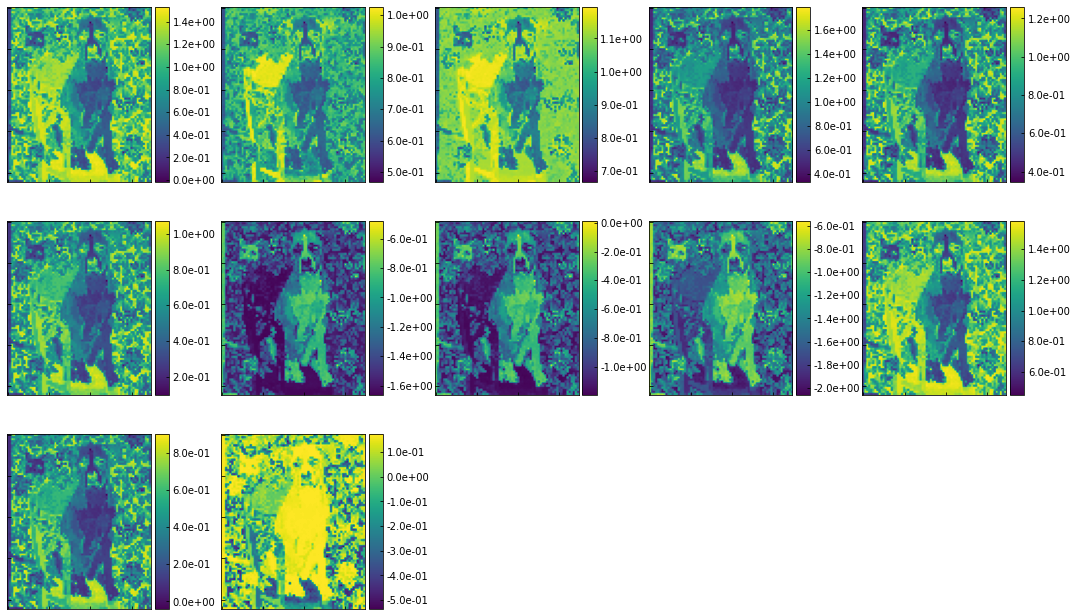

In [33]:
viz.embedding_maps(encode, image)


* This does not really mean too much because the latent variables are all competing with one another

# Let's Try with 3 latent variables

In [34]:
device = "cuda"

encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [35]:
model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=3, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(3, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [36]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


In [37]:
torch.manual_seed(0)
nn_util.Train(model, encoder, decoder, train_iterator, optimizer, 500)


 53%|█████▎    | 10/19 [00:00<00:00, 93.08it/s]

Epoch 0, Train Loss: 2.1234
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.52it/s]

Epoch 1, Train Loss: 2.1185
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.33it/s]

Epoch 2, Train Loss: 2.1135
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.83it/s]

Epoch 3, Train Loss: 2.1085
.............................


100%|██████████| 19/19 [00:00<00:00, 98.10it/s] 


Epoch 4, Train Loss: 2.1035
.............................
Epoch 5, Train Loss: 2.0984
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.57it/s]

Epoch 6, Train Loss: 2.0933
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.24it/s]

Epoch 7, Train Loss: 2.0882
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.65it/s]

Epoch 8, Train Loss: 2.0830
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.35it/s]

Epoch 9, Train Loss: 2.0777
.............................


100%|██████████| 19/19 [00:00<00:00, 97.41it/s]

Epoch 10, Train Loss: 2.0724
.............................



 47%|████▋     | 9/19 [00:00<00:00, 83.41it/s]

Epoch 11, Train Loss: 2.0670
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.68it/s]

Epoch 12, Train Loss: 2.0616
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.02it/s]

Epoch 13, Train Loss: 2.0561
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.96it/s]

Epoch 14, Train Loss: 2.0506
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.14it/s]

Epoch 15, Train Loss: 2.0449
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.77it/s]

Epoch 16, Train Loss: 2.0392
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.79it/s]

Epoch 17, Train Loss: 2.0334
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.56it/s]

Epoch 18, Train Loss: 2.0275
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.24it/s]

Epoch 19, Train Loss: 2.0216
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.49it/s]

Epoch 20, Train Loss: 2.0155
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.54it/s]

Epoch 21, Train Loss: 2.0094
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.47it/s]

Epoch 22, Train Loss: 2.0031
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.88it/s]

Epoch 23, Train Loss: 1.9967
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.41it/s]

Epoch 24, Train Loss: 1.9903
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.12it/s]

Epoch 25, Train Loss: 1.9837
.............................


100%|██████████| 19/19 [00:00<00:00, 97.65it/s]

Epoch 26, Train Loss: 1.9770
.............................



 53%|█████▎    | 10/19 [00:00<00:00, 97.69it/s]

Epoch 27, Train Loss: 1.9702
.............................
Epoch 28, Train Loss: 1.9632
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.72it/s]

Epoch 29, Train Loss: 1.9562
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.54it/s]

Epoch 30, Train Loss: 1.9490
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.67it/s]

Epoch 31, Train Loss: 1.9417
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.45it/s]

Epoch 32, Train Loss: 1.9342
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.72it/s]

Epoch 33, Train Loss: 1.9266
.............................


100%|██████████| 19/19 [00:00<00:00, 98.91it/s]


Epoch 34, Train Loss: 1.9189
.............................
Epoch 35, Train Loss: 1.9111
.............................


100%|██████████| 19/19 [00:00<00:00, 97.75it/s] 


Epoch 36, Train Loss: 1.9031
.............................
Epoch 37, Train Loss: 1.8949
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.48it/s]

Epoch 38, Train Loss: 1.8867
.............................


100%|██████████| 19/19 [00:00<00:00, 97.40it/s]

Epoch 39, Train Loss: 1.8782
.............................



 47%|████▋     | 9/19 [00:00<00:00, 83.99it/s]

Epoch 40, Train Loss: 1.8697
.............................


100%|██████████| 19/19 [00:00<00:00, 98.80it/s]


Epoch 41, Train Loss: 1.8610
.............................
Epoch 42, Train Loss: 1.8522
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.22it/s]

Epoch 43, Train Loss: 1.8433
.............................


100%|██████████| 19/19 [00:00<00:00, 98.97it/s]


Epoch 44, Train Loss: 1.8342
.............................
Epoch 45, Train Loss: 1.8250
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.61it/s]

Epoch 46, Train Loss: 1.8156
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.05it/s]

Epoch 47, Train Loss: 1.8062
.............................


100%|██████████| 19/19 [00:00<00:00, 98.41it/s]


Epoch 48, Train Loss: 1.7966
.............................
Epoch 49, Train Loss: 1.7869
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.33it/s]

Epoch 50, Train Loss: 1.7770
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.22it/s]

Epoch 51, Train Loss: 1.7671
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.16it/s]

Epoch 52, Train Loss: 1.7570
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.24it/s]

Epoch 53, Train Loss: 1.7468
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.87it/s]

Epoch 54, Train Loss: 1.7365
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.22it/s]

Epoch 55, Train Loss: 1.7260
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.20it/s]

Epoch 56, Train Loss: 1.7155
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.69it/s]

Epoch 57, Train Loss: 1.7049
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.35it/s]

Epoch 58, Train Loss: 1.6941
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.95it/s]

Epoch 59, Train Loss: 1.6833
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.55it/s]

Epoch 60, Train Loss: 1.6723
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.31it/s]

Epoch 61, Train Loss: 1.6613
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.01it/s]

Epoch 62, Train Loss: 1.6503
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.94it/s]

Epoch 63, Train Loss: 1.6391
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.34it/s]

Epoch 64, Train Loss: 1.6279
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.03it/s]

Epoch 65, Train Loss: 1.6167
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.31it/s]

Epoch 66, Train Loss: 1.6054
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.24it/s]

Epoch 67, Train Loss: 1.5942
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.22it/s]

Epoch 68, Train Loss: 1.5829
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.81it/s]

Epoch 69, Train Loss: 1.5717
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.68it/s]

Epoch 70, Train Loss: 1.5605
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.73it/s]

Epoch 71, Train Loss: 1.5493
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.97it/s]

Epoch 72, Train Loss: 1.5382
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.63it/s]

Epoch 73, Train Loss: 1.5272
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.64it/s]

Epoch 74, Train Loss: 1.5162
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.03it/s]

Epoch 75, Train Loss: 1.5052
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.95it/s]

Epoch 76, Train Loss: 1.4943
.............................


100%|██████████| 19/19 [00:00<00:00, 97.32it/s]

Epoch 77, Train Loss: 1.4835
.............................



 53%|█████▎    | 10/19 [00:00<00:00, 98.77it/s]

Epoch 78, Train Loss: 1.4727
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.97it/s]

Epoch 79, Train Loss: 1.4619
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.24it/s]

Epoch 80, Train Loss: 1.4512
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.26it/s]

Epoch 81, Train Loss: 1.4405
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.13it/s]

Epoch 82, Train Loss: 1.4298
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.83it/s]

Epoch 83, Train Loss: 1.4191
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.08it/s]

Epoch 84, Train Loss: 1.4084
.............................


100%|██████████| 19/19 [00:00<00:00, 98.23it/s]


Epoch 85, Train Loss: 1.3976
.............................
Epoch 86, Train Loss: 1.3868
.............................


100%|██████████| 19/19 [00:00<00:00, 99.11it/s]


Epoch 87, Train Loss: 1.3759
.............................
Epoch 88, Train Loss: 1.3650
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.18it/s]

Epoch 89, Train Loss: 1.3539
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.21it/s]

Epoch 90, Train Loss: 1.3428
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.65it/s]

Epoch 91, Train Loss: 1.3315
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.24it/s]

Epoch 92, Train Loss: 1.3201
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.60it/s]

Epoch 93, Train Loss: 1.3086
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.69it/s]

Epoch 94, Train Loss: 1.2969
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.25it/s]

Epoch 95, Train Loss: 1.2851
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.49it/s]

Epoch 96, Train Loss: 1.2731
.............................


100%|██████████| 19/19 [00:00<00:00, 99.11it/s]


Epoch 97, Train Loss: 1.2610
.............................
Epoch 98, Train Loss: 1.2487
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.02it/s]

Epoch 99, Train Loss: 1.2363
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.22it/s]

Epoch 100, Train Loss: 1.2237
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.32it/s]

Epoch 101, Train Loss: 1.2110
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.99it/s]

Epoch 102, Train Loss: 1.1981
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.09it/s]

Epoch 103, Train Loss: 1.1851
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.92it/s]

Epoch 104, Train Loss: 1.1720
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.70it/s]

Epoch 105, Train Loss: 1.1587
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.64it/s]

Epoch 106, Train Loss: 1.1453
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.52it/s]

Epoch 107, Train Loss: 1.1318
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.93it/s]

Epoch 108, Train Loss: 1.1183
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.05it/s]

Epoch 109, Train Loss: 1.1046
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.53it/s]

Epoch 110, Train Loss: 1.0909
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.05it/s]

Epoch 111, Train Loss: 1.0771
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.03it/s]

Epoch 112, Train Loss: 1.0633
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.63it/s]

Epoch 113, Train Loss: 1.0495
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.62it/s]

Epoch 114, Train Loss: 1.0356
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.52it/s]

Epoch 115, Train Loss: 1.0218
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.55it/s]

Epoch 116, Train Loss: 1.0080
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.16it/s]

Epoch 117, Train Loss: 0.9942
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.57it/s]

Epoch 118, Train Loss: 0.9804
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.21it/s]

Epoch 119, Train Loss: 0.9668
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.13it/s]

Epoch 120, Train Loss: 0.9531
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.72it/s]

Epoch 121, Train Loss: 0.9396
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.66it/s]

Epoch 122, Train Loss: 0.9261
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.69it/s]

Epoch 123, Train Loss: 0.9127
.............................


100%|██████████| 19/19 [00:00<00:00, 98.24it/s]


Epoch 124, Train Loss: 0.8995
.............................
Epoch 125, Train Loss: 0.8863
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.43it/s]

Epoch 126, Train Loss: 0.8733
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.31it/s]

Epoch 127, Train Loss: 0.8603
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.89it/s]

Epoch 128, Train Loss: 0.8475
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.71it/s]

Epoch 129, Train Loss: 0.8348
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.22it/s]

Epoch 130, Train Loss: 0.8222
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.83it/s]

Epoch 131, Train Loss: 0.8097
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.71it/s]

Epoch 132, Train Loss: 0.7973
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.70it/s]

Epoch 133, Train Loss: 0.7851
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.77it/s]

Epoch 134, Train Loss: 0.7729
.............................


100%|██████████| 19/19 [00:00<00:00, 97.15it/s]

Epoch 135, Train Loss: 0.7609
.............................



 53%|█████▎    | 10/19 [00:00<00:00, 95.15it/s]

Epoch 136, Train Loss: 0.7489
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.73it/s]

Epoch 137, Train Loss: 0.7371
.............................


100%|██████████| 19/19 [00:00<00:00, 98.53it/s]


Epoch 138, Train Loss: 0.7254
.............................
Epoch 139, Train Loss: 0.7137
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.34it/s]

Epoch 140, Train Loss: 0.7022
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.52it/s]

Epoch 141, Train Loss: 0.6908
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 99.77it/s]

Epoch 142, Train Loss: 0.6794
.............................


100%|██████████| 19/19 [00:00<00:00, 98.01it/s]


Epoch 143, Train Loss: 0.6682
.............................
Epoch 144, Train Loss: 0.6570
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.70it/s]

Epoch 145, Train Loss: 0.6460
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.78it/s]

Epoch 146, Train Loss: 0.6351
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.21it/s]

Epoch 147, Train Loss: 0.6243
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.89it/s]

Epoch 148, Train Loss: 0.6136
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.27it/s]

Epoch 149, Train Loss: 0.6030
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.19it/s]

Epoch 150, Train Loss: 0.5925
.............................


100%|██████████| 19/19 [00:00<00:00, 97.92it/s]


Epoch 151, Train Loss: 0.5822
.............................
Epoch 152, Train Loss: 0.5720
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.83it/s]

Epoch 153, Train Loss: 0.5619
.............................


 58%|█████▊    | 11/19 [00:00<00:00, 98.97it/s]

Epoch 154, Train Loss: 0.5520
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.84it/s]

Epoch 155, Train Loss: 0.5422
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.24it/s]

Epoch 156, Train Loss: 0.5326
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.51it/s]

Epoch 157, Train Loss: 0.5231
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.14it/s]

Epoch 158, Train Loss: 0.5138
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.40it/s]

Epoch 159, Train Loss: 0.5046
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.02it/s]

Epoch 160, Train Loss: 0.4956
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.23it/s]

Epoch 161, Train Loss: 0.4867
.............................


100%|██████████| 19/19 [00:00<00:00, 97.95it/s]


Epoch 162, Train Loss: 0.4780
.............................
Epoch 163, Train Loss: 0.4695
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.37it/s]

Epoch 164, Train Loss: 0.4611
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.04it/s]

Epoch 165, Train Loss: 0.4529
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.89it/s]

Epoch 166, Train Loss: 0.4448
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.10it/s]

Epoch 167, Train Loss: 0.4369
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.62it/s]

Epoch 168, Train Loss: 0.4292
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.98it/s]

Epoch 169, Train Loss: 0.4217
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.20it/s]

Epoch 170, Train Loss: 0.4143
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.86it/s]

Epoch 171, Train Loss: 0.4070
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.08it/s]

Epoch 172, Train Loss: 0.4000
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.98it/s]

Epoch 173, Train Loss: 0.3931
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.08it/s]

Epoch 174, Train Loss: 0.3864
.............................


100%|██████████| 19/19 [00:00<00:00, 98.40it/s]


Epoch 175, Train Loss: 0.3798
.............................
Epoch 176, Train Loss: 0.3734
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.14it/s]

Epoch 177, Train Loss: 0.3672
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.74it/s]

Epoch 178, Train Loss: 0.3611
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.81it/s]

Epoch 179, Train Loss: 0.3552
.............................


100%|██████████| 19/19 [00:00<00:00, 99.03it/s]


Epoch 180, Train Loss: 0.3494
.............................
Epoch 181, Train Loss: 0.3438
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.30it/s]

Epoch 182, Train Loss: 0.3383
.............................


 47%|████▋     | 9/19 [00:00<00:00, 79.60it/s]

Epoch 183, Train Loss: 0.3330
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.07it/s]

Epoch 184, Train Loss: 0.3279
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.03it/s]

Epoch 185, Train Loss: 0.3229
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.00it/s]

Epoch 186, Train Loss: 0.3180
.............................


100%|██████████| 19/19 [00:00<00:00, 97.53it/s]

Epoch 187, Train Loss: 0.3133
.............................



 53%|█████▎    | 10/19 [00:00<00:00, 98.82it/s]

Epoch 188, Train Loss: 0.3088
.............................


100%|██████████| 19/19 [00:00<00:00, 97.81it/s]

Epoch 189, Train Loss: 0.3043
.............................



 42%|████▏     | 8/19 [00:00<00:00, 79.80it/s]

Epoch 190, Train Loss: 0.3001
.............................
Epoch 191, Train Loss: 0.2959
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.46it/s]

Epoch 192, Train Loss: 0.2919
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.74it/s]

Epoch 193, Train Loss: 0.2880
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.90it/s]

Epoch 194, Train Loss: 0.2842
.............................


100%|██████████| 19/19 [00:00<00:00, 97.81it/s]

Epoch 195, Train Loss: 0.2806
.............................



 53%|█████▎    | 10/19 [00:00<00:00, 98.55it/s]

Epoch 196, Train Loss: 0.2771
.............................
Epoch 197, Train Loss: 0.2737
.............................


100%|██████████| 19/19 [00:00<00:00, 97.66it/s]

Epoch 198, Train Loss: 0.2704
.............................



 53%|█████▎    | 10/19 [00:00<00:00, 95.70it/s]

Epoch 199, Train Loss: 0.2672
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.87it/s]

Epoch 200, Train Loss: 0.2642
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.48it/s]

Epoch 201, Train Loss: 0.2612
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.38it/s]

Epoch 202, Train Loss: 0.2584
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.74it/s]

Epoch 203, Train Loss: 0.2556
.............................


100%|██████████| 19/19 [00:00<00:00, 97.25it/s]

Epoch 204, Train Loss: 0.2530
.............................



100%|██████████| 19/19 [00:00<00:00, 98.73it/s]


Epoch 205, Train Loss: 0.2505
.............................
Epoch 206, Train Loss: 0.2480
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.25it/s]

Epoch 207, Train Loss: 0.2456
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.88it/s]

Epoch 208, Train Loss: 0.2434
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.14it/s]

Epoch 209, Train Loss: 0.2412
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.14it/s]

Epoch 210, Train Loss: 0.2391
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.97it/s]

Epoch 211, Train Loss: 0.2371
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.42it/s]

Epoch 212, Train Loss: 0.2351
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.77it/s]

Epoch 213, Train Loss: 0.2332
.............................


100%|██████████| 19/19 [00:00<00:00, 98.28it/s]


Epoch 214, Train Loss: 0.2314
.............................
Epoch 215, Train Loss: 0.2297
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.51it/s]

Epoch 216, Train Loss: 0.2280
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.88it/s]

Epoch 217, Train Loss: 0.2264
.............................


 58%|█████▊    | 11/19 [00:00<00:00, 101.32it/s]

Epoch 218, Train Loss: 0.2249
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.44it/s]

Epoch 219, Train Loss: 0.2234
.............................


100%|██████████| 19/19 [00:00<00:00, 98.72it/s]


Epoch 220, Train Loss: 0.2220
.............................
Epoch 221, Train Loss: 0.2206
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.48it/s]

Epoch 222, Train Loss: 0.2193
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.42it/s]

Epoch 223, Train Loss: 0.2181
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.03it/s]

Epoch 224, Train Loss: 0.2168
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.84it/s]

Epoch 225, Train Loss: 0.2157
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.58it/s]

Epoch 226, Train Loss: 0.2146
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.51it/s]

Epoch 227, Train Loss: 0.2135
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.17it/s]

Epoch 228, Train Loss: 0.2124
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.80it/s]

Epoch 229, Train Loss: 0.2114
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.86it/s]

Epoch 230, Train Loss: 0.2104
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.14it/s]

Epoch 231, Train Loss: 0.2095
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.85it/s]

Epoch 232, Train Loss: 0.2086
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.21it/s]

Epoch 233, Train Loss: 0.2077
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.81it/s]

Epoch 234, Train Loss: 0.2069
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.53it/s]

Epoch 235, Train Loss: 0.2061
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.84it/s]

Epoch 236, Train Loss: 0.2053
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.12it/s]

Epoch 237, Train Loss: 0.2045
.............................


100%|██████████| 19/19 [00:00<00:00, 97.20it/s]

Epoch 238, Train Loss: 0.2038
.............................



 47%|████▋     | 9/19 [00:00<00:00, 87.70it/s]

Epoch 239, Train Loss: 0.2030
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.48it/s]

Epoch 240, Train Loss: 0.2023
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.71it/s]

Epoch 241, Train Loss: 0.2016
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.54it/s]

Epoch 242, Train Loss: 0.2010
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.92it/s]

Epoch 243, Train Loss: 0.2003
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.68it/s]

Epoch 244, Train Loss: 0.1997
.............................


100%|██████████| 19/19 [00:00<00:00, 97.62it/s]


Epoch 245, Train Loss: 0.1991
.............................
Epoch 246, Train Loss: 0.1985
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.26it/s]

Epoch 247, Train Loss: 0.1979
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.46it/s]

Epoch 248, Train Loss: 0.1973
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.65it/s]

Epoch 249, Train Loss: 0.1967
.............................


100%|██████████| 19/19 [00:00<00:00, 97.95it/s]


Epoch 250, Train Loss: 0.1962
.............................
Epoch 251, Train Loss: 0.1956
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.51it/s]

Epoch 252, Train Loss: 0.1951
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.86it/s]

Epoch 253, Train Loss: 0.1946
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.76it/s]

Epoch 254, Train Loss: 0.1941
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.82it/s]

Epoch 255, Train Loss: 0.1935
.............................


100%|██████████| 19/19 [00:00<00:00, 98.84it/s]


Epoch 256, Train Loss: 0.1930
.............................
Epoch 257, Train Loss: 0.1925
.............................


100%|██████████| 19/19 [00:00<00:00, 98.14it/s]


Epoch 258, Train Loss: 0.1920
.............................
Epoch 259, Train Loss: 0.1916
.............................


100%|██████████| 19/19 [00:00<00:00, 99.24it/s]


Epoch 260, Train Loss: 0.1911
.............................
Epoch 261, Train Loss: 0.1906
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.80it/s]

Epoch 262, Train Loss: 0.1901
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.90it/s]

Epoch 263, Train Loss: 0.1897
.............................


100%|██████████| 19/19 [00:00<00:00, 97.56it/s]

Epoch 264, Train Loss: 0.1892
.............................
Epoch 265, Train Loss: 0.1887
.............................



100%|██████████| 19/19 [00:00<00:00, 99.93it/s]


Epoch 266, Train Loss: 0.1883
.............................
Epoch 267, Train Loss: 0.1878
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.42it/s]

Epoch 268, Train Loss: 0.1874
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.39it/s]

Epoch 269, Train Loss: 0.1869
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.99it/s]

Epoch 270, Train Loss: 0.1865
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.05it/s]

Epoch 271, Train Loss: 0.1860
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.65it/s]

Epoch 272, Train Loss: 0.1856
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.88it/s]

Epoch 273, Train Loss: 0.1851
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.56it/s]

Epoch 274, Train Loss: 0.1847
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.06it/s]

Epoch 275, Train Loss: 0.1843
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.97it/s]

Epoch 276, Train Loss: 0.1838
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.68it/s]

Epoch 277, Train Loss: 0.1834
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.94it/s]

Epoch 278, Train Loss: 0.1830
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 279, Train Loss: 0.1825
.............................
Epoch 280, Train Loss: 0.1821
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.86it/s]

Epoch 281, Train Loss: 0.1817
.............................


100%|██████████| 19/19 [00:00<00:00, 97.91it/s]


Epoch 282, Train Loss: 0.1813
.............................
Epoch 283, Train Loss: 0.1808
.............................


100%|██████████| 19/19 [00:00<00:00, 98.06it/s]


Epoch 284, Train Loss: 0.1804
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.87it/s]

Epoch 285, Train Loss: 0.1800
.............................
Epoch 286, Train Loss: 0.1796
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.82it/s]

Epoch 287, Train Loss: 0.1792
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.67it/s]

Epoch 288, Train Loss: 0.1787
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.75it/s]

Epoch 289, Train Loss: 0.1783
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 99.50it/s]

Epoch 290, Train Loss: 0.1779
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 99.19it/s]

Epoch 291, Train Loss: 0.1775
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.28it/s]

Epoch 292, Train Loss: 0.1771
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.00it/s]

Epoch 293, Train Loss: 0.1767
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.46it/s]

Epoch 294, Train Loss: 0.1763
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.07it/s]

Epoch 295, Train Loss: 0.1759
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.38it/s]

Epoch 296, Train Loss: 0.1755
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.25it/s]

Epoch 297, Train Loss: 0.1751
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.79it/s]

Epoch 298, Train Loss: 0.1747
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.94it/s]

Epoch 299, Train Loss: 0.1743
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.57it/s]

Epoch 300, Train Loss: 0.1739
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.59it/s]

Epoch 301, Train Loss: 0.1735
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.83it/s]

Epoch 302, Train Loss: 0.1731
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.07it/s]

Epoch 303, Train Loss: 0.1727
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 88.48it/s]

Epoch 304, Train Loss: 0.1723
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.13it/s]

Epoch 305, Train Loss: 0.1719
.............................


100%|██████████| 19/19 [00:00<00:00, 99.67it/s]


Epoch 306, Train Loss: 0.1715
.............................
Epoch 307, Train Loss: 0.1711
.............................


100%|██████████| 19/19 [00:00<00:00, 99.14it/s]


Epoch 308, Train Loss: 0.1707
.............................
Epoch 309, Train Loss: 0.1703
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.47it/s]

Epoch 310, Train Loss: 0.1699
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.81it/s]

Epoch 311, Train Loss: 0.1695
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.46it/s]

Epoch 312, Train Loss: 0.1692
.............................


100%|██████████| 19/19 [00:00<00:00, 97.31it/s]

Epoch 313, Train Loss: 0.1688
.............................



100%|██████████| 19/19 [00:00<00:00, 98.81it/s]


Epoch 314, Train Loss: 0.1684
.............................
Epoch 315, Train Loss: 0.1680
.............................


100%|██████████| 19/19 [00:00<00:00, 98.48it/s]


Epoch 316, Train Loss: 0.1676
.............................
Epoch 317, Train Loss: 0.1673
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 318, Train Loss: 0.1669
.............................
Epoch 319, Train Loss: 0.1665
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.78it/s]

Epoch 320, Train Loss: 0.1662
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 321, Train Loss: 0.1658
.............................
Epoch 322, Train Loss: 0.1654
.............................


100%|██████████| 19/19 [00:00<00:00, 98.75it/s]


Epoch 323, Train Loss: 0.1651
.............................
Epoch 324, Train Loss: 0.1647
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.69it/s]

Epoch 325, Train Loss: 0.1643
.............................


100%|██████████| 19/19 [00:00<00:00, 97.17it/s]

Epoch 326, Train Loss: 0.1640
.............................



100%|██████████| 19/19 [00:00<00:00, 98.70it/s] 


Epoch 327, Train Loss: 0.1636
.............................
Epoch 328, Train Loss: 0.1633
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 89.15it/s]

Epoch 329, Train Loss: 0.1629
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.84it/s]

Epoch 330, Train Loss: 0.1626
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.32it/s]

Epoch 331, Train Loss: 0.1622
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.41it/s]

Epoch 332, Train Loss: 0.1619
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.75it/s]

Epoch 333, Train Loss: 0.1615
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.97it/s]

Epoch 334, Train Loss: 0.1612
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.78it/s]

Epoch 335, Train Loss: 0.1608
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.84it/s]

Epoch 336, Train Loss: 0.1605
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.15it/s]

Epoch 337, Train Loss: 0.1602
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 89.80it/s]

Epoch 338, Train Loss: 0.1598
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.31it/s]

Epoch 339, Train Loss: 0.1595
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.37it/s]

Epoch 340, Train Loss: 0.1591
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.50it/s]

Epoch 341, Train Loss: 0.1588
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.40it/s]

Epoch 342, Train Loss: 0.1585
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.59it/s]

Epoch 343, Train Loss: 0.1582
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.58it/s]

Epoch 344, Train Loss: 0.1578
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.06it/s]

Epoch 345, Train Loss: 0.1575
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.97it/s]

Epoch 346, Train Loss: 0.1572
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.64it/s]

Epoch 347, Train Loss: 0.1569
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.58it/s]

Epoch 348, Train Loss: 0.1566
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.69it/s]

Epoch 349, Train Loss: 0.1562
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.94it/s]

Epoch 350, Train Loss: 0.1559
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.56it/s]

Epoch 351, Train Loss: 0.1556
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.53it/s]

Epoch 352, Train Loss: 0.1553
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.73it/s]

Epoch 353, Train Loss: 0.1550
.............................


100%|██████████| 19/19 [00:00<00:00, 97.33it/s]

Epoch 354, Train Loss: 0.1547
.............................



100%|██████████| 19/19 [00:00<00:00, 97.94it/s] 

Epoch 355, Train Loss: 0.1544
.............................



100%|██████████| 19/19 [00:00<00:00, 98.21it/s] 

Epoch 356, Train Loss: 0.1541
.............................
Epoch 357, Train Loss: 0.1538
.............................



 47%|████▋     | 9/19 [00:00<00:00, 89.72it/s]

Epoch 358, Train Loss: 0.1535
.............................
Epoch 359, Train Loss: 0.1532
.............................


100%|██████████| 19/19 [00:00<00:00, 97.28it/s]

Epoch 360, Train Loss: 0.1529
.............................



 53%|█████▎    | 10/19 [00:00<00:00, 99.77it/s]

Epoch 361, Train Loss: 0.1526
.............................


100%|██████████| 19/19 [00:00<00:00, 99.06it/s] 


Epoch 362, Train Loss: 0.1523
.............................
Epoch 363, Train Loss: 0.1520
.............................


100%|██████████| 19/19 [00:00<00:00, 98.94it/s] 


Epoch 364, Train Loss: 0.1518
.............................
Epoch 365, Train Loss: 0.1515
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.44it/s]

Epoch 366, Train Loss: 0.1512
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.54it/s]

Epoch 367, Train Loss: 0.1509
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.54it/s]

Epoch 368, Train Loss: 0.1506
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 99.16it/s]

Epoch 369, Train Loss: 0.1503
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.30it/s]

Epoch 370, Train Loss: 0.1501
.............................


100%|██████████| 19/19 [00:00<00:00, 98.60it/s]


Epoch 371, Train Loss: 0.1498
.............................
Epoch 372, Train Loss: 0.1495
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.33it/s]

Epoch 373, Train Loss: 0.1492
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.18it/s]

Epoch 374, Train Loss: 0.1490
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.84it/s]

Epoch 375, Train Loss: 0.1487
.............................


100%|██████████| 19/19 [00:00<00:00, 98.77it/s]


Epoch 376, Train Loss: 0.1484
.............................
Epoch 377, Train Loss: 0.1482
.............................


100%|██████████| 19/19 [00:00<00:00, 98.79it/s]


Epoch 378, Train Loss: 0.1479
.............................
Epoch 379, Train Loss: 0.1477
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 99.28it/s]

Epoch 380, Train Loss: 0.1474
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.11it/s]

Epoch 381, Train Loss: 0.1471
.............................


100%|██████████| 19/19 [00:00<00:00, 98.59it/s]


Epoch 382, Train Loss: 0.1469
.............................
Epoch 383, Train Loss: 0.1466
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.54it/s]

Epoch 384, Train Loss: 0.1464
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.40it/s]

Epoch 385, Train Loss: 0.1461
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.76it/s]

Epoch 386, Train Loss: 0.1459
.............................


100%|██████████| 19/19 [00:00<00:00, 98.27it/s]


Epoch 387, Train Loss: 0.1456
.............................
Epoch 388, Train Loss: 0.1454
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.63it/s]

Epoch 389, Train Loss: 0.1451
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.66it/s]

Epoch 390, Train Loss: 0.1449
.............................


100%|██████████| 19/19 [00:00<00:00, 98.05it/s]


Epoch 391, Train Loss: 0.1446
.............................
Epoch 392, Train Loss: 0.1444
.............................


100%|██████████| 19/19 [00:00<00:00, 98.62it/s]


Epoch 393, Train Loss: 0.1442
.............................
Epoch 394, Train Loss: 0.1439
.............................


100%|██████████| 19/19 [00:00<00:00, 100.15it/s]


Epoch 395, Train Loss: 0.1437
.............................
Epoch 396, Train Loss: 0.1434
.............................


100%|██████████| 19/19 [00:00<00:00, 98.91it/s]


Epoch 397, Train Loss: 0.1432
.............................
Epoch 398, Train Loss: 0.1430
.............................


100%|██████████| 19/19 [00:00<00:00, 96.97it/s]

Epoch 399, Train Loss: 0.1427
.............................



100%|██████████| 19/19 [00:00<00:00, 97.87it/s]

Epoch 400, Train Loss: 0.1425
.............................



100%|██████████| 19/19 [00:00<00:00, 98.31it/s]


Epoch 401, Train Loss: 0.1423
.............................
Epoch 402, Train Loss: 0.1421
.............................
Epoch 403, Train Loss: 0.1418
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.21it/s]

Epoch 404, Train Loss: 0.1416
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.10it/s]

Epoch 405, Train Loss: 0.1414
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.82it/s]

Epoch 406, Train Loss: 0.1412
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.30it/s]

Epoch 407, Train Loss: 0.1410
.............................


100%|██████████| 19/19 [00:00<00:00, 98.22it/s]


Epoch 408, Train Loss: 0.1407
.............................
Epoch 409, Train Loss: 0.1405
.............................


100%|██████████| 19/19 [00:00<00:00, 99.33it/s] 


Epoch 410, Train Loss: 0.1403
.............................
Epoch 411, Train Loss: 0.1401
.............................


100%|██████████| 19/19 [00:00<00:00, 98.62it/s]


Epoch 412, Train Loss: 0.1399
.............................
Epoch 413, Train Loss: 0.1397
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.88it/s]

Epoch 414, Train Loss: 0.1395
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.21it/s]

Epoch 415, Train Loss: 0.1393
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.49it/s]

Epoch 416, Train Loss: 0.1391
.............................


100%|██████████| 19/19 [00:00<00:00, 98.83it/s]


Epoch 417, Train Loss: 0.1389
.............................
Epoch 418, Train Loss: 0.1387
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.11it/s]

Epoch 419, Train Loss: 0.1385
.............................


100%|██████████| 19/19 [00:00<00:00, 97.35it/s]

Epoch 420, Train Loss: 0.1383
.............................



100%|██████████| 19/19 [00:00<00:00, 98.41it/s]


Epoch 421, Train Loss: 0.1381
.............................
Epoch 422, Train Loss: 0.1379
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.45it/s]

Epoch 423, Train Loss: 0.1377
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 98.88it/s]

Epoch 424, Train Loss: 0.1375
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.24it/s]

Epoch 425, Train Loss: 0.1373
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.15it/s]

Epoch 426, Train Loss: 0.1371
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.44it/s]

Epoch 427, Train Loss: 0.1369
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.28it/s]

Epoch 428, Train Loss: 0.1367
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.07it/s]

Epoch 429, Train Loss: 0.1366
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.61it/s]

Epoch 430, Train Loss: 0.1364
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.90it/s]

Epoch 431, Train Loss: 0.1362
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.78it/s]

Epoch 432, Train Loss: 0.1360
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.85it/s]

Epoch 433, Train Loss: 0.1358
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.98it/s]

Epoch 434, Train Loss: 0.1357
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.35it/s]

Epoch 435, Train Loss: 0.1355
.............................


100%|██████████| 19/19 [00:00<00:00, 98.27it/s]


Epoch 436, Train Loss: 0.1353
.............................
Epoch 437, Train Loss: 0.1352
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.71it/s]

Epoch 438, Train Loss: 0.1350
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.92it/s]

Epoch 439, Train Loss: 0.1348
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 95.89it/s]

Epoch 440, Train Loss: 0.1347
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.53it/s]

Epoch 441, Train Loss: 0.1345
.............................


100%|██████████| 19/19 [00:00<00:00, 98.66it/s]


Epoch 442, Train Loss: 0.1343
.............................
Epoch 443, Train Loss: 0.1342
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.62it/s]

Epoch 444, Train Loss: 0.1340
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.12it/s]

Epoch 445, Train Loss: 0.1339
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 87.82it/s]

Epoch 446, Train Loss: 0.1337
.............................


100%|██████████| 19/19 [00:00<00:00, 98.41it/s]


Epoch 447, Train Loss: 0.1335
.............................
Epoch 448, Train Loss: 0.1334
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.85it/s]

Epoch 449, Train Loss: 0.1332
.............................


100%|██████████| 19/19 [00:00<00:00, 100.40it/s]


Epoch 450, Train Loss: 0.1331
.............................
Epoch 451, Train Loss: 0.1329
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.31it/s]

Epoch 452, Train Loss: 0.1328
.............................


100%|██████████| 19/19 [00:00<00:00, 97.80it/s] 


Epoch 453, Train Loss: 0.1326
.............................
Epoch 454, Train Loss: 0.1325
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.43it/s]

Epoch 455, Train Loss: 0.1324
.............................


100%|██████████| 19/19 [00:00<00:00, 98.25it/s]


Epoch 456, Train Loss: 0.1322
.............................
Epoch 457, Train Loss: 0.1321
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.70it/s]

Epoch 458, Train Loss: 0.1319
.............................


100%|██████████| 19/19 [00:00<00:00, 98.71it/s]


Epoch 459, Train Loss: 0.1318
.............................
Epoch 460, Train Loss: 0.1317
.............................


100%|██████████| 19/19 [00:00<00:00, 98.61it/s]


Epoch 461, Train Loss: 0.1315
.............................
Epoch 462, Train Loss: 0.1314
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 99.03it/s]

Epoch 463, Train Loss: 0.1313
.............................


100%|██████████| 19/19 [00:00<00:00, 99.02it/s] 


Epoch 464, Train Loss: 0.1311
.............................
Epoch 465, Train Loss: 0.1310
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.16it/s]

Epoch 466, Train Loss: 0.1309
.............................


100%|██████████| 19/19 [00:00<00:00, 99.72it/s]


Epoch 467, Train Loss: 0.1307
.............................
Epoch 468, Train Loss: 0.1306
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 97.89it/s]

Epoch 469, Train Loss: 0.1305
.............................


100%|██████████| 19/19 [00:00<00:00, 99.37it/s] 


Epoch 470, Train Loss: 0.1304
.............................
Epoch 471, Train Loss: 0.1302
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.02it/s]

Epoch 472, Train Loss: 0.1301
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.15it/s]

Epoch 473, Train Loss: 0.1300
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 94.45it/s]

Epoch 474, Train Loss: 0.1299
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.35it/s]

Epoch 475, Train Loss: 0.1297
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.09it/s]

Epoch 476, Train Loss: 0.1296
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.28it/s]

Epoch 477, Train Loss: 0.1295
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.75it/s]

Epoch 478, Train Loss: 0.1294
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.91it/s]

Epoch 479, Train Loss: 0.1293
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.26it/s]

Epoch 480, Train Loss: 0.1292
.............................


100%|██████████| 19/19 [00:00<00:00, 98.92it/s] 


Epoch 481, Train Loss: 0.1290
.............................
Epoch 482, Train Loss: 0.1289
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 483, Train Loss: 0.1288
.............................
Epoch 484, Train Loss: 0.1287
.............................


100%|██████████| 19/19 [00:00<00:00, 100.69it/s]


Epoch 485, Train Loss: 0.1286
.............................
Epoch 486, Train Loss: 0.1285
.............................


100%|██████████| 19/19 [00:00<00:00, 98.97it/s]


Epoch 487, Train Loss: 0.1284
.............................
Epoch 488, Train Loss: 0.1283
.............................


100%|██████████| 19/19 [00:00<00:00, 98.34it/s] 

Epoch 489, Train Loss: 0.1281
.............................



 47%|████▋     | 9/19 [00:00<00:00, 83.07it/s]

Epoch 490, Train Loss: 0.1280
.............................
Epoch 491, Train Loss: 0.1279
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.14it/s]

Epoch 492, Train Loss: 0.1278
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 493, Train Loss: 0.1277
.............................
Epoch 494, Train Loss: 0.1276
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 96.26it/s]

Epoch 495, Train Loss: 0.1275
.............................


100%|██████████| 19/19 [00:00<00:00, 99.09it/s]


Epoch 496, Train Loss: 0.1274
.............................
Epoch 497, Train Loss: 0.1273
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.81it/s]

Epoch 498, Train Loss: 0.1272
.............................


100%|██████████| 19/19 [00:00<00:00, 95.72it/s]


Epoch 499, Train Loss: 0.1271
.............................


In [38]:
encode, decode = nn_util.transform_nn(dog_data, encoder, decoder)


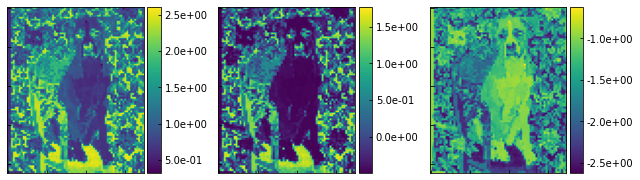

In [39]:
viz.embedding_maps(encode, image)


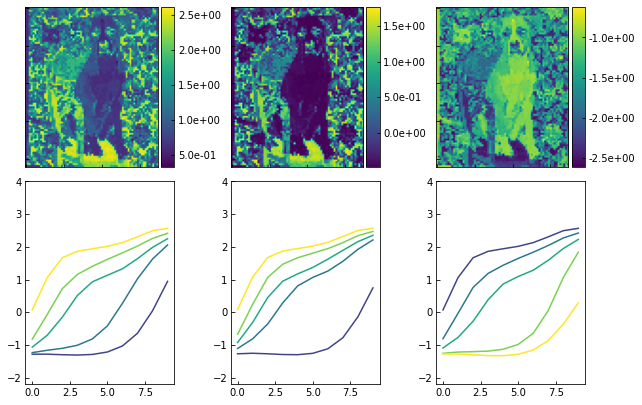

In [40]:
viz.latent_generator(decoder, encode, image, 5, 10)


* This once again is very hard to interpret and the spectra do not really contain the necessary details

# Disentanglement
## Regularization
![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/L1_reg.png?raw=true)


In [41]:
latent_dim = 12

# input (batch,)
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)  # add a relu
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [42]:
device = "cuda"

encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [43]:
model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [44]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


In [45]:
torch.manual_seed(0)
nn_util.Train(
    model, encoder, decoder, train_iterator, optimizer, 500, coef=1e-3, mse=False
)


 53%|█████▎    | 10/19 [00:00<00:00, 91.64it/s]

Epoch 0, Train Loss: 2.1541
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.08it/s]

Epoch 1, Train Loss: 2.1475
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.88it/s]

Epoch 2, Train Loss: 2.1411
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.51it/s]

Epoch 3, Train Loss: 2.1347
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.67it/s]

Epoch 4, Train Loss: 2.1284
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.65it/s]

Epoch 5, Train Loss: 2.1221
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.22it/s]

Epoch 6, Train Loss: 2.1159
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.05it/s]

Epoch 7, Train Loss: 2.1098
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.47it/s]

Epoch 8, Train Loss: 2.1037
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.66it/s]

Epoch 9, Train Loss: 2.0977
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.69it/s]

Epoch 10, Train Loss: 2.0917
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.68it/s]

Epoch 11, Train Loss: 2.0857
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.99it/s]

Epoch 12, Train Loss: 2.0798
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.32it/s]

Epoch 13, Train Loss: 2.0739
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.50it/s]

Epoch 14, Train Loss: 2.0680
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.51it/s]

Epoch 15, Train Loss: 2.0621
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.59it/s]

Epoch 16, Train Loss: 2.0563
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.88it/s]

Epoch 17, Train Loss: 2.0504
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.98it/s]

Epoch 18, Train Loss: 2.0445
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.93it/s]

Epoch 19, Train Loss: 2.0386
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.81it/s]

Epoch 20, Train Loss: 2.0327
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.74it/s]

Epoch 21, Train Loss: 2.0268
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.41it/s]

Epoch 22, Train Loss: 2.0209
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.54it/s]

Epoch 23, Train Loss: 2.0149
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.49it/s]

Epoch 24, Train Loss: 2.0089
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.19it/s]

Epoch 25, Train Loss: 2.0028
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.12it/s]

Epoch 26, Train Loss: 1.9967
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 89.61it/s]

Epoch 27, Train Loss: 1.9906
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.86it/s]

Epoch 28, Train Loss: 1.9843
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.53it/s]

Epoch 29, Train Loss: 1.9780
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.97it/s]

Epoch 30, Train Loss: 1.9716
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.75it/s]

Epoch 31, Train Loss: 1.9652
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.26it/s]

Epoch 32, Train Loss: 1.9586
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.41it/s]

Epoch 33, Train Loss: 1.9523
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.16it/s]

Epoch 34, Train Loss: 1.9463
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.30it/s]

Epoch 35, Train Loss: 1.9405
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.13it/s]

Epoch 36, Train Loss: 1.9348
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.34it/s]

Epoch 37, Train Loss: 1.9292
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.98it/s]

Epoch 38, Train Loss: 1.9237
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.98it/s]

Epoch 39, Train Loss: 1.9183
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.60it/s]

Epoch 40, Train Loss: 1.9129
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 88.53it/s]

Epoch 41, Train Loss: 1.9076
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.73it/s]

Epoch 42, Train Loss: 1.9023
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.24it/s]

Epoch 43, Train Loss: 1.8974
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.44it/s]

Epoch 44, Train Loss: 1.8928
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.29it/s]

Epoch 45, Train Loss: 1.8883
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.99it/s]

Epoch 46, Train Loss: 1.8838
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.13it/s]

Epoch 47, Train Loss: 1.8794
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.45it/s]

Epoch 48, Train Loss: 1.8750
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.21it/s]

Epoch 49, Train Loss: 1.8705
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.37it/s]

Epoch 50, Train Loss: 1.8661
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.90it/s]

Epoch 51, Train Loss: 1.8617
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.80it/s]

Epoch 52, Train Loss: 1.8572
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.45it/s]

Epoch 53, Train Loss: 1.8527
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.62it/s]

Epoch 54, Train Loss: 1.8482
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.01it/s]

Epoch 55, Train Loss: 1.8436
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.81it/s]

Epoch 56, Train Loss: 1.8389
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.03it/s]

Epoch 57, Train Loss: 1.8342
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.55it/s]

Epoch 58, Train Loss: 1.8294
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.11it/s]

Epoch 59, Train Loss: 1.8245
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.96it/s]

Epoch 60, Train Loss: 1.8196
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.48it/s]

Epoch 61, Train Loss: 1.8146
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.76it/s]

Epoch 62, Train Loss: 1.8095
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.52it/s]

Epoch 63, Train Loss: 1.8042
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.94it/s]

Epoch 64, Train Loss: 1.7989
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.13it/s]

Epoch 65, Train Loss: 1.7935
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.79it/s]

Epoch 66, Train Loss: 1.7880
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.08it/s]

Epoch 67, Train Loss: 1.7824
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.81it/s]

Epoch 68, Train Loss: 1.7767
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.11it/s]

Epoch 69, Train Loss: 1.7709
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.14it/s]

Epoch 70, Train Loss: 1.7650
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.55it/s]

Epoch 71, Train Loss: 1.7589
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.60it/s]

Epoch 72, Train Loss: 1.7527
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.50it/s]

Epoch 73, Train Loss: 1.7464
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.72it/s]

Epoch 74, Train Loss: 1.7400
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.76it/s]

Epoch 75, Train Loss: 1.7334
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.97it/s]

Epoch 76, Train Loss: 1.7266
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.38it/s]

Epoch 77, Train Loss: 1.7198
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.49it/s]

Epoch 78, Train Loss: 1.7127
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.48it/s]

Epoch 79, Train Loss: 1.7056
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.66it/s]

Epoch 80, Train Loss: 1.6982
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.77it/s]

Epoch 81, Train Loss: 1.6908
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.35it/s]

Epoch 82, Train Loss: 1.6832
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.98it/s]

Epoch 83, Train Loss: 1.6757
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.47it/s]

Epoch 84, Train Loss: 1.6682
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.52it/s]

Epoch 85, Train Loss: 1.6607
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.58it/s]

Epoch 86, Train Loss: 1.6531
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.66it/s]

Epoch 87, Train Loss: 1.6453
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.98it/s]

Epoch 88, Train Loss: 1.6374
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.87it/s]

Epoch 89, Train Loss: 1.6294
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.50it/s]

Epoch 90, Train Loss: 1.6212
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.61it/s]

Epoch 91, Train Loss: 1.6129
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.81it/s]

Epoch 92, Train Loss: 1.6044
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.38it/s]

Epoch 93, Train Loss: 1.5959
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.18it/s]

Epoch 94, Train Loss: 1.5872
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.64it/s]

Epoch 95, Train Loss: 1.5783
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.46it/s]

Epoch 96, Train Loss: 1.5694
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.28it/s]

Epoch 97, Train Loss: 1.5604
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.64it/s]

Epoch 98, Train Loss: 1.5513
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.48it/s]

Epoch 99, Train Loss: 1.5421
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.23it/s]

Epoch 100, Train Loss: 1.5328
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.94it/s]

Epoch 101, Train Loss: 1.5235
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.29it/s]

Epoch 102, Train Loss: 1.5141
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.30it/s]

Epoch 103, Train Loss: 1.5046
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.06it/s]

Epoch 104, Train Loss: 1.4951
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.05it/s]

Epoch 105, Train Loss: 1.4856
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.60it/s]

Epoch 106, Train Loss: 1.4760
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.05it/s]

Epoch 107, Train Loss: 1.4664
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.41it/s]

Epoch 108, Train Loss: 1.4568
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.69it/s]

Epoch 109, Train Loss: 1.4472
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.40it/s]

Epoch 110, Train Loss: 1.4376
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.03it/s]

Epoch 111, Train Loss: 1.4279
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.63it/s]

Epoch 112, Train Loss: 1.4183
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.06it/s]

Epoch 113, Train Loss: 1.4087
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.08it/s]

Epoch 114, Train Loss: 1.3991
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.03it/s]

Epoch 115, Train Loss: 1.3895
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.43it/s]

Epoch 116, Train Loss: 1.3800
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.58it/s]

Epoch 117, Train Loss: 1.3705
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.72it/s]

Epoch 118, Train Loss: 1.3610
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.60it/s]

Epoch 119, Train Loss: 1.3517
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.26it/s]

Epoch 120, Train Loss: 1.3423
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.91it/s]

Epoch 121, Train Loss: 1.3331
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.07it/s]

Epoch 122, Train Loss: 1.3239
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.11it/s]

Epoch 123, Train Loss: 1.3148
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.61it/s]

Epoch 124, Train Loss: 1.3058
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.78it/s]

Epoch 125, Train Loss: 1.2969
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.38it/s]

Epoch 126, Train Loss: 1.2881
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.79it/s]

Epoch 127, Train Loss: 1.2794
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.92it/s]

Epoch 128, Train Loss: 1.2708
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.05it/s]

Epoch 129, Train Loss: 1.2623
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.60it/s]

Epoch 130, Train Loss: 1.2539
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.66it/s]

Epoch 131, Train Loss: 1.2457
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.77it/s]

Epoch 132, Train Loss: 1.2376
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.77it/s]

Epoch 133, Train Loss: 1.2297
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.71it/s]

Epoch 134, Train Loss: 1.2218
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.93it/s]

Epoch 135, Train Loss: 1.2141
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.54it/s]

Epoch 136, Train Loss: 1.2066
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.59it/s]

Epoch 137, Train Loss: 1.1992
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.49it/s]

Epoch 138, Train Loss: 1.1919
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.30it/s]

Epoch 139, Train Loss: 1.1848
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.06it/s]

Epoch 140, Train Loss: 1.1778
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.79it/s]

Epoch 141, Train Loss: 1.1710
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.82it/s]

Epoch 142, Train Loss: 1.1642
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.90it/s]

Epoch 143, Train Loss: 1.1576
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.87it/s]

Epoch 144, Train Loss: 1.1511
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.68it/s]

Epoch 145, Train Loss: 1.1447
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.36it/s]

Epoch 146, Train Loss: 1.1384
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.27it/s]

Epoch 147, Train Loss: 1.1322
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.97it/s]

Epoch 148, Train Loss: 1.1260
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.73it/s]

Epoch 149, Train Loss: 1.1198
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.62it/s]

Epoch 150, Train Loss: 1.1136
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.47it/s]

Epoch 151, Train Loss: 1.1074
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.54it/s]

Epoch 152, Train Loss: 1.1011
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.58it/s]

Epoch 153, Train Loss: 1.0948
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.00it/s]

Epoch 154, Train Loss: 1.0884
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.27it/s]

Epoch 155, Train Loss: 1.0820
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.70it/s]

Epoch 156, Train Loss: 1.0758
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.41it/s]

Epoch 157, Train Loss: 1.0696
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.09it/s]

Epoch 158, Train Loss: 1.0634
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.85it/s]

Epoch 159, Train Loss: 1.0571
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.97it/s]

Epoch 160, Train Loss: 1.0507
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.41it/s]

Epoch 161, Train Loss: 1.0442
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.89it/s]

Epoch 162, Train Loss: 1.0376
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.00it/s]

Epoch 163, Train Loss: 1.0308
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.20it/s]

Epoch 164, Train Loss: 1.0239
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.56it/s]

Epoch 165, Train Loss: 1.0167
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.37it/s]

Epoch 166, Train Loss: 1.0093
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.82it/s]

Epoch 167, Train Loss: 1.0016
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.26it/s]

Epoch 168, Train Loss: 0.9936
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.88it/s]

Epoch 169, Train Loss: 0.9852
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 89.66it/s]

Epoch 170, Train Loss: 0.9765
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.80it/s]

Epoch 171, Train Loss: 0.9674
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.36it/s]

Epoch 172, Train Loss: 0.9578
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.51it/s]

Epoch 173, Train Loss: 0.9477
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.82it/s]

Epoch 174, Train Loss: 0.9370
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.72it/s]

Epoch 175, Train Loss: 0.9258
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.83it/s]

Epoch 176, Train Loss: 0.9140
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.49it/s]

Epoch 177, Train Loss: 0.9016
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.65it/s]

Epoch 178, Train Loss: 0.8885
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.57it/s]

Epoch 179, Train Loss: 0.8748
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.69it/s]

Epoch 180, Train Loss: 0.8605
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.31it/s]

Epoch 181, Train Loss: 0.8455
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.48it/s]

Epoch 182, Train Loss: 0.8300
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.04it/s]

Epoch 183, Train Loss: 0.8141
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.18it/s]

Epoch 184, Train Loss: 0.7978
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.74it/s]

Epoch 185, Train Loss: 0.7813
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.80it/s]

Epoch 186, Train Loss: 0.7647
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.02it/s]

Epoch 187, Train Loss: 0.7480
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.25it/s]

Epoch 188, Train Loss: 0.7315
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.70it/s]

Epoch 189, Train Loss: 0.7152
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.07it/s]

Epoch 190, Train Loss: 0.6992
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.69it/s]

Epoch 191, Train Loss: 0.6836
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.60it/s]

Epoch 192, Train Loss: 0.6685
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.56it/s]

Epoch 193, Train Loss: 0.6538
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.29it/s]

Epoch 194, Train Loss: 0.6397
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.31it/s]

Epoch 195, Train Loss: 0.6262
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.83it/s]

Epoch 196, Train Loss: 0.6132
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.16it/s]

Epoch 197, Train Loss: 0.6007
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.63it/s]

Epoch 198, Train Loss: 0.5889
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.27it/s]

Epoch 199, Train Loss: 0.5778
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.87it/s]

Epoch 200, Train Loss: 0.5673
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.29it/s]

Epoch 201, Train Loss: 0.5575
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.46it/s]

Epoch 202, Train Loss: 0.5483
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.03it/s]

Epoch 203, Train Loss: 0.5396
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.66it/s]

Epoch 204, Train Loss: 0.5314
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.10it/s]

Epoch 205, Train Loss: 0.5237
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 89.65it/s]

Epoch 206, Train Loss: 0.5164
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.12it/s]

Epoch 207, Train Loss: 0.5095
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.73it/s]

Epoch 208, Train Loss: 0.5029
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.88it/s]

Epoch 209, Train Loss: 0.4966
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.70it/s]

Epoch 210, Train Loss: 0.4907
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.32it/s]

Epoch 211, Train Loss: 0.4850
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.42it/s]

Epoch 212, Train Loss: 0.4796
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.17it/s]

Epoch 213, Train Loss: 0.4745
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.83it/s]

Epoch 214, Train Loss: 0.4696
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.97it/s]

Epoch 215, Train Loss: 0.4649
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.08it/s]

Epoch 216, Train Loss: 0.4604
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.27it/s]

Epoch 217, Train Loss: 0.4560
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.54it/s]

Epoch 218, Train Loss: 0.4519
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.93it/s]

Epoch 219, Train Loss: 0.4479
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.25it/s]

Epoch 220, Train Loss: 0.4441
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.17it/s]

Epoch 221, Train Loss: 0.4404
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 89.78it/s]

Epoch 222, Train Loss: 0.4369
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.88it/s]

Epoch 223, Train Loss: 0.4334
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.54it/s]

Epoch 224, Train Loss: 0.4301
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.57it/s]

Epoch 225, Train Loss: 0.4270
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.99it/s]

Epoch 226, Train Loss: 0.4239
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.85it/s]

Epoch 227, Train Loss: 0.4210
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.50it/s]

Epoch 228, Train Loss: 0.4181
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.38it/s]

Epoch 229, Train Loss: 0.4153
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.72it/s]

Epoch 230, Train Loss: 0.4126
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.04it/s]

Epoch 231, Train Loss: 0.4100
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.97it/s]

Epoch 232, Train Loss: 0.4075
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.78it/s]

Epoch 233, Train Loss: 0.4050
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.98it/s]

Epoch 234, Train Loss: 0.4026
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.10it/s]

Epoch 235, Train Loss: 0.4003
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.57it/s]

Epoch 236, Train Loss: 0.3980
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.03it/s]

Epoch 237, Train Loss: 0.3957
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.50it/s]

Epoch 238, Train Loss: 0.3936
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.68it/s]

Epoch 239, Train Loss: 0.3914
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.62it/s]

Epoch 240, Train Loss: 0.3893
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.27it/s]

Epoch 241, Train Loss: 0.3873
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.15it/s]

Epoch 242, Train Loss: 0.3853
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.13it/s]

Epoch 243, Train Loss: 0.3834
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.88it/s]

Epoch 244, Train Loss: 0.3814
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.57it/s]

Epoch 245, Train Loss: 0.3796
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.14it/s]

Epoch 246, Train Loss: 0.3777
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.14it/s]

Epoch 247, Train Loss: 0.3759
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.38it/s]

Epoch 248, Train Loss: 0.3741
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.31it/s]

Epoch 249, Train Loss: 0.3724
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.50it/s]

Epoch 250, Train Loss: 0.3706
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.83it/s]

Epoch 251, Train Loss: 0.3689
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.71it/s]

Epoch 252, Train Loss: 0.3673
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.76it/s]

Epoch 253, Train Loss: 0.3656
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.31it/s]

Epoch 254, Train Loss: 0.3640
.............................


 37%|███▋      | 7/19 [00:00<00:00, 67.40it/s]

Epoch 255, Train Loss: 0.3624
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.39it/s]

Epoch 256, Train Loss: 0.3608
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.05it/s]

Epoch 257, Train Loss: 0.3593
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.47it/s]

Epoch 258, Train Loss: 0.3577
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.30it/s]

Epoch 259, Train Loss: 0.3562
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.89it/s]

Epoch 260, Train Loss: 0.3548
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.19it/s]

Epoch 261, Train Loss: 0.3533
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.73it/s]

Epoch 262, Train Loss: 0.3519
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.47it/s]

Epoch 263, Train Loss: 0.3505
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.03it/s]

Epoch 264, Train Loss: 0.3491
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 89.55it/s]

Epoch 265, Train Loss: 0.3477
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.63it/s]

Epoch 266, Train Loss: 0.3464
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.97it/s]

Epoch 267, Train Loss: 0.3451
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.84it/s]

Epoch 268, Train Loss: 0.3438
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.98it/s]

Epoch 269, Train Loss: 0.3426
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.54it/s]

Epoch 270, Train Loss: 0.3413
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.72it/s]

Epoch 271, Train Loss: 0.3401
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.73it/s]

Epoch 272, Train Loss: 0.3390
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.00it/s]

Epoch 273, Train Loss: 0.3378
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.92it/s]

Epoch 274, Train Loss: 0.3367
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.15it/s]

Epoch 275, Train Loss: 0.3356
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.57it/s]

Epoch 276, Train Loss: 0.3345
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.48it/s]

Epoch 277, Train Loss: 0.3335
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.90it/s]

Epoch 278, Train Loss: 0.3324
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.86it/s]

Epoch 279, Train Loss: 0.3314
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.48it/s]

Epoch 280, Train Loss: 0.3305
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.88it/s]

Epoch 281, Train Loss: 0.3295
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.83it/s]

Epoch 282, Train Loss: 0.3286
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.11it/s]

Epoch 283, Train Loss: 0.3277
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.63it/s]

Epoch 284, Train Loss: 0.3268
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.06it/s]

Epoch 285, Train Loss: 0.3259
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.93it/s]

Epoch 286, Train Loss: 0.3251
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.85it/s]

Epoch 287, Train Loss: 0.3243
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.97it/s]

Epoch 288, Train Loss: 0.3235
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.43it/s]

Epoch 289, Train Loss: 0.3227
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.81it/s]

Epoch 290, Train Loss: 0.3220
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.02it/s]

Epoch 291, Train Loss: 0.3212
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.97it/s]

Epoch 292, Train Loss: 0.3205
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.35it/s]

Epoch 293, Train Loss: 0.3198
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.73it/s]

Epoch 294, Train Loss: 0.3191
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.84it/s]

Epoch 295, Train Loss: 0.3184
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.09it/s]

Epoch 296, Train Loss: 0.3178
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.17it/s]

Epoch 297, Train Loss: 0.3171
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.77it/s]

Epoch 298, Train Loss: 0.3165
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.70it/s]

Epoch 299, Train Loss: 0.3159
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.81it/s]

Epoch 300, Train Loss: 0.3153
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.93it/s]

Epoch 301, Train Loss: 0.3147
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.21it/s]

Epoch 302, Train Loss: 0.3142
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.66it/s]

Epoch 303, Train Loss: 0.3136
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.39it/s]

Epoch 304, Train Loss: 0.3130
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.13it/s]

Epoch 305, Train Loss: 0.3125
.............................


 37%|███▋      | 7/19 [00:00<00:00, 67.34it/s]

Epoch 306, Train Loss: 0.3120
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.77it/s]

Epoch 307, Train Loss: 0.3115
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.56it/s]

Epoch 308, Train Loss: 0.3110
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.12it/s]

Epoch 309, Train Loss: 0.3105
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.89it/s]

Epoch 310, Train Loss: 0.3100
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.83it/s]

Epoch 311, Train Loss: 0.3095
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.90it/s]

Epoch 312, Train Loss: 0.3090
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.47it/s]

Epoch 313, Train Loss: 0.3085
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.41it/s]

Epoch 314, Train Loss: 0.3080
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.24it/s]

Epoch 315, Train Loss: 0.3076
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.76it/s]

Epoch 316, Train Loss: 0.3071
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.39it/s]

Epoch 317, Train Loss: 0.3067
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.70it/s]

Epoch 318, Train Loss: 0.3062
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.52it/s]

Epoch 319, Train Loss: 0.3058
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.12it/s]

Epoch 320, Train Loss: 0.3053
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.53it/s]

Epoch 321, Train Loss: 0.3049
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.22it/s]

Epoch 322, Train Loss: 0.3045
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.48it/s]

Epoch 323, Train Loss: 0.3040
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.23it/s]

Epoch 324, Train Loss: 0.3036
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.31it/s]

Epoch 325, Train Loss: 0.3032
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.04it/s]

Epoch 326, Train Loss: 0.3027
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.49it/s]

Epoch 327, Train Loss: 0.3023
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.54it/s]

Epoch 328, Train Loss: 0.3019
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.15it/s]

Epoch 329, Train Loss: 0.3015
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.78it/s]

Epoch 330, Train Loss: 0.3011
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.56it/s]

Epoch 331, Train Loss: 0.3006
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.63it/s]

Epoch 332, Train Loss: 0.3002
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.75it/s]

Epoch 333, Train Loss: 0.2998
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.24it/s]

Epoch 334, Train Loss: 0.2994
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.67it/s]

Epoch 335, Train Loss: 0.2990
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.68it/s]

Epoch 336, Train Loss: 0.2986
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.65it/s]

Epoch 337, Train Loss: 0.2981
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.79it/s]

Epoch 338, Train Loss: 0.2977
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.87it/s]

Epoch 339, Train Loss: 0.2973
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.48it/s]

Epoch 340, Train Loss: 0.2969
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.20it/s]

Epoch 341, Train Loss: 0.2965
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.35it/s]

Epoch 342, Train Loss: 0.2961
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.70it/s]

Epoch 343, Train Loss: 0.2957
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.71it/s]

Epoch 344, Train Loss: 0.2953
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.47it/s]

Epoch 345, Train Loss: 0.2949
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.66it/s]

Epoch 346, Train Loss: 0.2945
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.72it/s]

Epoch 347, Train Loss: 0.2940
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.44it/s]

Epoch 348, Train Loss: 0.2936
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.49it/s]

Epoch 349, Train Loss: 0.2932
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.11it/s]

Epoch 350, Train Loss: 0.2928
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.77it/s]

Epoch 351, Train Loss: 0.2924
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.86it/s]

Epoch 352, Train Loss: 0.2920
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.42it/s]

Epoch 353, Train Loss: 0.2916
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.35it/s]

Epoch 354, Train Loss: 0.2912
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.17it/s]

Epoch 355, Train Loss: 0.2908
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.20it/s]

Epoch 356, Train Loss: 0.2904
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.69it/s]

Epoch 357, Train Loss: 0.2900
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.77it/s]

Epoch 358, Train Loss: 0.2896
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.30it/s]

Epoch 359, Train Loss: 0.2892
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.66it/s]

Epoch 360, Train Loss: 0.2888
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.62it/s]

Epoch 361, Train Loss: 0.2884
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.86it/s]

Epoch 362, Train Loss: 0.2880
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.92it/s]

Epoch 363, Train Loss: 0.2876
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.42it/s]

Epoch 364, Train Loss: 0.2872
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.98it/s]

Epoch 365, Train Loss: 0.2868
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.40it/s]

Epoch 366, Train Loss: 0.2865
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.44it/s]

Epoch 367, Train Loss: 0.2861
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.63it/s]

Epoch 368, Train Loss: 0.2857
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.33it/s]

Epoch 369, Train Loss: 0.2853
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.59it/s]

Epoch 370, Train Loss: 0.2849
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.04it/s]

Epoch 371, Train Loss: 0.2845
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.56it/s]

Epoch 372, Train Loss: 0.2841
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.74it/s]

Epoch 373, Train Loss: 0.2837
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.21it/s]

Epoch 374, Train Loss: 0.2833
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.90it/s]

Epoch 375, Train Loss: 0.2829
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.41it/s]

Epoch 376, Train Loss: 0.2825
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.38it/s]

Epoch 377, Train Loss: 0.2821
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.60it/s]

Epoch 378, Train Loss: 0.2818
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.68it/s]

Epoch 379, Train Loss: 0.2814
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.00it/s]

Epoch 380, Train Loss: 0.2810
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.42it/s]

Epoch 381, Train Loss: 0.2806
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.68it/s]

Epoch 382, Train Loss: 0.2802
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.29it/s]

Epoch 383, Train Loss: 0.2798
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.19it/s]

Epoch 384, Train Loss: 0.2794
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.48it/s]

Epoch 385, Train Loss: 0.2790
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.54it/s]

Epoch 386, Train Loss: 0.2787
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.84it/s]

Epoch 387, Train Loss: 0.2783
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.82it/s]

Epoch 388, Train Loss: 0.2779
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.70it/s]

Epoch 389, Train Loss: 0.2775
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.74it/s]

Epoch 390, Train Loss: 0.2771
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.75it/s]

Epoch 391, Train Loss: 0.2767
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.32it/s]

Epoch 392, Train Loss: 0.2763
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.47it/s]

Epoch 393, Train Loss: 0.2759
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.74it/s]

Epoch 394, Train Loss: 0.2756
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.58it/s]

Epoch 395, Train Loss: 0.2752
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.89it/s]

Epoch 396, Train Loss: 0.2748
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.95it/s]

Epoch 397, Train Loss: 0.2744
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.83it/s]

Epoch 398, Train Loss: 0.2740
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.78it/s]

Epoch 399, Train Loss: 0.2736
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 93.06it/s]

Epoch 400, Train Loss: 0.2733
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.41it/s]

Epoch 401, Train Loss: 0.2729
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.53it/s]

Epoch 402, Train Loss: 0.2725
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.20it/s]

Epoch 403, Train Loss: 0.2721
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.90it/s]

Epoch 404, Train Loss: 0.2717
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.56it/s]

Epoch 405, Train Loss: 0.2713
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.89it/s]

Epoch 406, Train Loss: 0.2710
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.56it/s]

Epoch 407, Train Loss: 0.2706
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.96it/s]

Epoch 408, Train Loss: 0.2702
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.26it/s]

Epoch 409, Train Loss: 0.2698
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.94it/s]

Epoch 410, Train Loss: 0.2694
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.08it/s]

Epoch 411, Train Loss: 0.2691
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.92it/s]

Epoch 412, Train Loss: 0.2687
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.29it/s]

Epoch 413, Train Loss: 0.2683
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.52it/s]

Epoch 414, Train Loss: 0.2679
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.70it/s]

Epoch 415, Train Loss: 0.2675
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.10it/s]

Epoch 416, Train Loss: 0.2671
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.31it/s]

Epoch 417, Train Loss: 0.2668
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.94it/s]

Epoch 418, Train Loss: 0.2664
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.66it/s]

Epoch 419, Train Loss: 0.2660
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.44it/s]

Epoch 420, Train Loss: 0.2656
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.65it/s]

Epoch 421, Train Loss: 0.2652
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.65it/s]

Epoch 422, Train Loss: 0.2649
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.17it/s]

Epoch 423, Train Loss: 0.2645
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.40it/s]

Epoch 424, Train Loss: 0.2641
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.07it/s]

Epoch 425, Train Loss: 0.2637
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.56it/s]

Epoch 426, Train Loss: 0.2633
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.06it/s]

Epoch 427, Train Loss: 0.2630
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.73it/s]

Epoch 428, Train Loss: 0.2626
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.48it/s]

Epoch 429, Train Loss: 0.2622
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.43it/s]

Epoch 430, Train Loss: 0.2618
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.33it/s]

Epoch 431, Train Loss: 0.2614
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.97it/s]

Epoch 432, Train Loss: 0.2610
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.92it/s]

Epoch 433, Train Loss: 0.2607
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.88it/s]

Epoch 434, Train Loss: 0.2603
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.22it/s]

Epoch 435, Train Loss: 0.2599
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.23it/s]

Epoch 436, Train Loss: 0.2595
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.90it/s]

Epoch 437, Train Loss: 0.2591
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.74it/s]

Epoch 438, Train Loss: 0.2587
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.38it/s]

Epoch 439, Train Loss: 0.2584
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.12it/s]

Epoch 440, Train Loss: 0.2580
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.58it/s]

Epoch 441, Train Loss: 0.2576
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.25it/s]

Epoch 442, Train Loss: 0.2572
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.30it/s]

Epoch 443, Train Loss: 0.2568
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.78it/s]

Epoch 444, Train Loss: 0.2564
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.60it/s]

Epoch 445, Train Loss: 0.2561
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.10it/s]

Epoch 446, Train Loss: 0.2557
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.21it/s]

Epoch 447, Train Loss: 0.2553
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.74it/s]

Epoch 448, Train Loss: 0.2549
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.34it/s]

Epoch 449, Train Loss: 0.2545
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.44it/s]

Epoch 450, Train Loss: 0.2541
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.81it/s]

Epoch 451, Train Loss: 0.2538
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.27it/s]

Epoch 452, Train Loss: 0.2534
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.53it/s]

Epoch 453, Train Loss: 0.2530
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.35it/s]

Epoch 454, Train Loss: 0.2526
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.18it/s]

Epoch 455, Train Loss: 0.2522
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.36it/s]

Epoch 456, Train Loss: 0.2518
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.64it/s]

Epoch 457, Train Loss: 0.2514
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.08it/s]

Epoch 458, Train Loss: 0.2511
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.99it/s]

Epoch 459, Train Loss: 0.2507
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.76it/s]

Epoch 460, Train Loss: 0.2503
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.24it/s]

Epoch 461, Train Loss: 0.2499
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.25it/s]

Epoch 462, Train Loss: 0.2495
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 89.75it/s]

Epoch 463, Train Loss: 0.2491
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.50it/s]

Epoch 464, Train Loss: 0.2488
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.76it/s]

Epoch 465, Train Loss: 0.2484
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.36it/s]

Epoch 466, Train Loss: 0.2480
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.69it/s]

Epoch 467, Train Loss: 0.2476
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.10it/s]

Epoch 468, Train Loss: 0.2472
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.70it/s]

Epoch 469, Train Loss: 0.2469
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.27it/s]

Epoch 470, Train Loss: 0.2465
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.43it/s]

Epoch 471, Train Loss: 0.2461
.............................


 47%|████▋     | 9/19 [00:00<00:00, 83.89it/s]

Epoch 472, Train Loss: 0.2457
.............................


 47%|████▋     | 9/19 [00:00<00:00, 84.88it/s]

Epoch 473, Train Loss: 0.2453
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.77it/s]

Epoch 474, Train Loss: 0.2450
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.73it/s]

Epoch 475, Train Loss: 0.2446
.............................


 47%|████▋     | 9/19 [00:00<00:00, 88.54it/s]

Epoch 476, Train Loss: 0.2442
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.75it/s]

Epoch 477, Train Loss: 0.2438
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.07it/s]

Epoch 478, Train Loss: 0.2435
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.31it/s]

Epoch 479, Train Loss: 0.2431
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.25it/s]

Epoch 480, Train Loss: 0.2427
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.86it/s]

Epoch 481, Train Loss: 0.2423
.............................


 47%|████▋     | 9/19 [00:00<00:00, 89.53it/s]

Epoch 482, Train Loss: 0.2420
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.38it/s]

Epoch 483, Train Loss: 0.2416
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.87it/s]

Epoch 484, Train Loss: 0.2412
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 88.80it/s]

Epoch 485, Train Loss: 0.2409
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.30it/s]

Epoch 486, Train Loss: 0.2405
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.63it/s]

Epoch 487, Train Loss: 0.2401
.............................


 47%|████▋     | 9/19 [00:00<00:00, 86.28it/s]

Epoch 488, Train Loss: 0.2398
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 90.47it/s]

Epoch 489, Train Loss: 0.2394
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 89.78it/s]

Epoch 490, Train Loss: 0.2391
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.04it/s]

Epoch 491, Train Loss: 0.2387
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.19it/s]

Epoch 492, Train Loss: 0.2383
.............................


 47%|████▋     | 9/19 [00:00<00:00, 87.13it/s]

Epoch 493, Train Loss: 0.2380
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.37it/s]

Epoch 494, Train Loss: 0.2376
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 91.71it/s]

Epoch 495, Train Loss: 0.2373
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.99it/s]

Epoch 496, Train Loss: 0.2369
.............................


 53%|█████▎    | 10/19 [00:00<00:00, 92.56it/s]

Epoch 497, Train Loss: 0.2365
.............................


 47%|████▋     | 9/19 [00:00<00:00, 85.14it/s]

Epoch 498, Train Loss: 0.2362
.............................


100%|██████████| 19/19 [00:00<00:00, 85.86it/s]

Epoch 499, Train Loss: 0.2358
.............................


In [46]:
encode, decode = nn_util.transform_nn(dog_data, encoder, decoder)


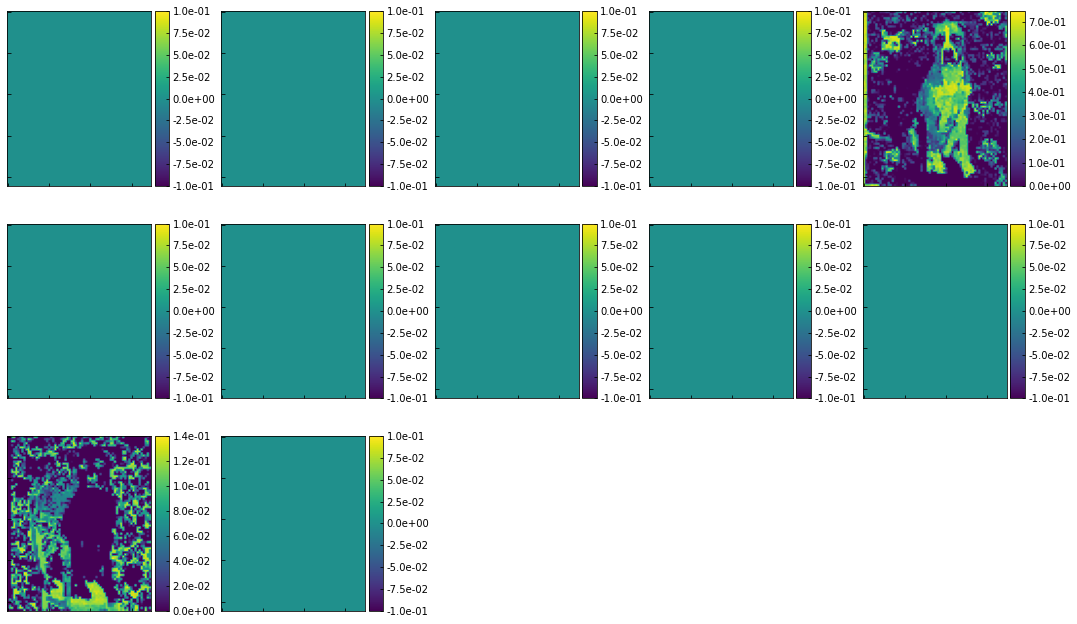

In [47]:
viz.embedding_maps(encode, image)


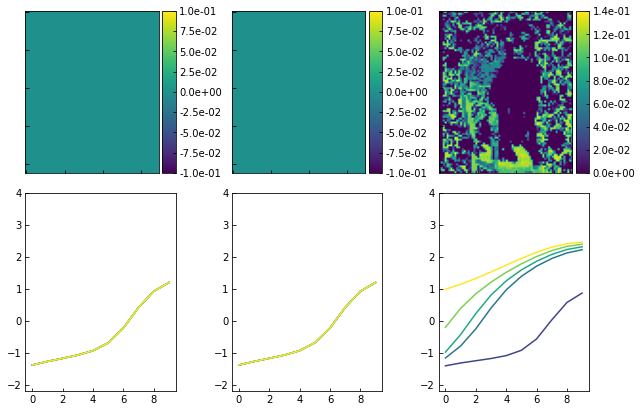

In [48]:
viz.latent_generator(decoder, encode, image, 5, 10, indx=[2, 3, 10])


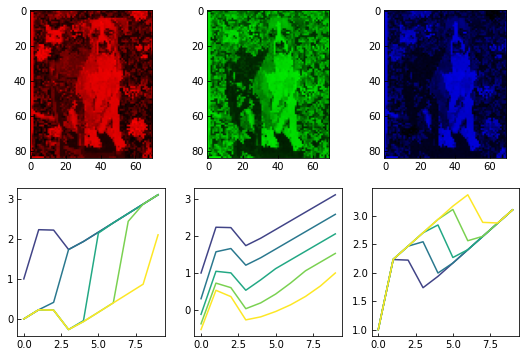

In [49]:
fig, ax = viz.layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = util.generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)


In [50]:
from IPython.display import HTML

# Youtube
HTML(
    '<iframe width="560" height="315" src="https://www.youtube.com/embed/ElTwQClLsW0" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)


# Beta Variational Autoencoder
* Constrict and sample the latent space from some prior distribution --> generally a gaussian distribution

# Normal Autoencoder
![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/VAE1.png?raw=true)

# VAE
* Encoder identifies some distribution --> generates from that distribution
![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/VAE2.png?raw=true)

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/VAE3.png?raw=true)

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/VAE4.png?raw=true)

In [51]:
latent_dim = 12

# input (batch,)
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()
        self.mn = nn.Linear(self.latent_dim, self.latent_dim)
        self.sd = nn.Linear(self.latent_dim, self.latent_dim)

    def forward(self, x):
        #     x = x.transpose(1,2)

        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)
        mn = self.mn(x)
        sd = self.sd(x)
        std = torch.exp(sd * 0.5).cuda()
        eps = torch.normal(0, 1, size=std.size()).cuda()
        out = eps.mul(std).add_(mn).cuda()

        return out, mn, sd


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [52]:
device = "cuda"

encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [53]:
def Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    epochs,
    coef=0,
    coef_1=0,
    ln_parm=1,
    beta_step_size=0,
    epoch_per_beta=10,
    initial_epochs=10,
):

    N_EPOCHS = epochs
    best_train_loss = float("inf")

    for epoch in range(N_EPOCHS):

        if epoch < initial_epochs:

            beta = 0
        else:

            beta = ((epoch - initial_epochs) // epoch_per_beta + 1) * beta_step_size

        train_loss = nn_util.loss_function(
            model,
            encoder,
            decoder,
            train_iterator,
            optimizer,
            coef,
            coef_1,
            ln_parm,
            beta=beta,
            mse=False,
        )

        train_loss /= len(train_iterator)
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}")
        print(".............................")

        if (
            (epoch - initial_epochs) // epoch_per_beta
            == (epoch - initial_epochs) / epoch_per_beta
        ) and (epoch >= initial_epochs):

            best_train_loss = float("inf")

        if best_train_loss > train_loss:
            best_train_loss = train_loss
            patience_counter = 1
            checkpoint = {
                "net": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "encoder": encoder.state_dict(),
                "decoder": decoder.state_dict(),
            }
            if epoch >= 0:
                torch.save(
                    checkpoint, f"./test__Train_Loss:{train_loss:.4f}-{epoch}.pkl"
                )


In [54]:
torch.manual_seed(0)
Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    beta_step_size=0.05,
    epoch_per_beta=100,
    initial_epochs=200,
)


 32%|███▏      | 6/19 [00:00<00:00, 55.01it/s]

Epoch 0, Train Loss: 2.1055
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.59it/s]

Epoch 1, Train Loss: 2.0683
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.37it/s]

Epoch 2, Train Loss: 2.0328
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.81it/s]

Epoch 3, Train Loss: 2.0028
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.30it/s]

Epoch 4, Train Loss: 1.9607
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.86it/s]

Epoch 5, Train Loss: 1.9102
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.76it/s]

Epoch 6, Train Loss: 1.8534
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.04it/s]

Epoch 7, Train Loss: 1.7744
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.88it/s]

Epoch 8, Train Loss: 1.6892
.............................


 37%|███▋      | 7/19 [00:00<00:00, 67.40it/s]

Epoch 9, Train Loss: 1.5761
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.56it/s]

Epoch 10, Train Loss: 1.4694
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.99it/s]

Epoch 11, Train Loss: 1.3667
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.31it/s]

Epoch 12, Train Loss: 1.2435
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.29it/s]

Epoch 13, Train Loss: 1.1345
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.85it/s]

Epoch 14, Train Loss: 1.0432
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.99it/s]

Epoch 15, Train Loss: 0.9562
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.36it/s]

Epoch 16, Train Loss: 0.8767
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.28it/s]

Epoch 17, Train Loss: 0.7903
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.16it/s]

Epoch 18, Train Loss: 0.7102
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.81it/s]

Epoch 19, Train Loss: 0.6191
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.96it/s]

Epoch 20, Train Loss: 0.5343
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.02it/s]

Epoch 21, Train Loss: 0.4568
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.66it/s]

Epoch 22, Train Loss: 0.3811
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.17it/s]

Epoch 23, Train Loss: 0.3270
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.43it/s]

Epoch 24, Train Loss: 0.2903
.............................


 37%|███▋      | 7/19 [00:00<00:00, 61.53it/s]

Epoch 25, Train Loss: 0.2678
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.37it/s]

Epoch 26, Train Loss: 0.2524
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.08it/s]

Epoch 27, Train Loss: 0.2431
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.93it/s]

Epoch 28, Train Loss: 0.2323
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.89it/s]

Epoch 29, Train Loss: 0.2246
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.14it/s]

Epoch 30, Train Loss: 0.2181
.............................


 37%|███▋      | 7/19 [00:00<00:00, 62.62it/s]

Epoch 31, Train Loss: 0.2118
.............................


 37%|███▋      | 7/19 [00:00<00:00, 67.65it/s]

Epoch 32, Train Loss: 0.2067
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.29it/s]

Epoch 33, Train Loss: 0.2032
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.63it/s]

Epoch 34, Train Loss: 0.1971
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.17it/s]

Epoch 35, Train Loss: 0.1941
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.73it/s]

Epoch 36, Train Loss: 0.1889
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.94it/s]

Epoch 37, Train Loss: 0.1866
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.25it/s]

Epoch 38, Train Loss: 0.1833
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.50it/s]

Epoch 39, Train Loss: 0.1795
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.82it/s]

Epoch 40, Train Loss: 0.1766
.............................


 47%|████▋     | 9/19 [00:00<00:00, 79.58it/s]

Epoch 41, Train Loss: 0.1738
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.55it/s]

Epoch 42, Train Loss: 0.1706
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.06it/s]

Epoch 43, Train Loss: 0.1681
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.29it/s]

Epoch 44, Train Loss: 0.1656
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.69it/s]

Epoch 45, Train Loss: 0.1624
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.61it/s]

Epoch 46, Train Loss: 0.1593
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.66it/s]

Epoch 47, Train Loss: 0.1567
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.44it/s]

Epoch 48, Train Loss: 0.1543
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.50it/s]

Epoch 49, Train Loss: 0.1518
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.47it/s]

Epoch 50, Train Loss: 0.1490
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.20it/s]

Epoch 51, Train Loss: 0.1467
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.23it/s]

Epoch 52, Train Loss: 0.1437
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.48it/s]

Epoch 53, Train Loss: 0.1406
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.87it/s]

Epoch 54, Train Loss: 0.1384
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.70it/s]

Epoch 55, Train Loss: 0.1359
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.99it/s]

Epoch 56, Train Loss: 0.1334
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.64it/s]

Epoch 57, Train Loss: 0.1316
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.22it/s]

Epoch 58, Train Loss: 0.1295
.............................


 37%|███▋      | 7/19 [00:00<00:00, 62.54it/s]

Epoch 59, Train Loss: 0.1274
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.36it/s]

Epoch 60, Train Loss: 0.1256
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.19it/s]

Epoch 61, Train Loss: 0.1238
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.49it/s]

Epoch 62, Train Loss: 0.1223
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.31it/s]

Epoch 63, Train Loss: 0.1209
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.68it/s]

Epoch 64, Train Loss: 0.1192
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.98it/s]

Epoch 65, Train Loss: 0.1179
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.79it/s]

Epoch 66, Train Loss: 0.1169
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.96it/s]

Epoch 67, Train Loss: 0.1154
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.96it/s]

Epoch 68, Train Loss: 0.1144
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.71it/s]

Epoch 69, Train Loss: 0.1133
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.52it/s]

Epoch 70, Train Loss: 0.1121
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.31it/s]

Epoch 71, Train Loss: 0.1111
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.00it/s]

Epoch 72, Train Loss: 0.1099
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.47it/s]

Epoch 73, Train Loss: 0.1089
.............................


 37%|███▋      | 7/19 [00:00<00:00, 62.89it/s]

Epoch 74, Train Loss: 0.1077
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.44it/s]

Epoch 75, Train Loss: 0.1067
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.50it/s]

Epoch 76, Train Loss: 0.1054
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.61it/s]

Epoch 77, Train Loss: 0.1041
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.99it/s]

Epoch 78, Train Loss: 0.1030
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.55it/s]

Epoch 79, Train Loss: 0.1017
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.31it/s]

Epoch 80, Train Loss: 0.1003
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.81it/s]

Epoch 81, Train Loss: 0.0990
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.24it/s]

Epoch 82, Train Loss: 0.0975
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.46it/s]

Epoch 83, Train Loss: 0.0957
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.68it/s]

Epoch 84, Train Loss: 0.0940
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.30it/s]

Epoch 85, Train Loss: 0.0920
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.51it/s]

Epoch 86, Train Loss: 0.0900
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.91it/s]

Epoch 87, Train Loss: 0.0878
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.88it/s]

Epoch 88, Train Loss: 0.0857
.............................


 37%|███▋      | 7/19 [00:00<00:00, 59.64it/s]

Epoch 89, Train Loss: 0.0829
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.89it/s]

Epoch 90, Train Loss: 0.0802
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.74it/s]

Epoch 91, Train Loss: 0.0777
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.70it/s]

Epoch 92, Train Loss: 0.0757
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.41it/s]

Epoch 93, Train Loss: 0.0738
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.21it/s]

Epoch 94, Train Loss: 0.0722
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.87it/s]

Epoch 95, Train Loss: 0.0708
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.91it/s]

Epoch 96, Train Loss: 0.0696
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.90it/s]

Epoch 97, Train Loss: 0.0686
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.38it/s]

Epoch 98, Train Loss: 0.0674
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.44it/s]

Epoch 99, Train Loss: 0.0663
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.82it/s]

Epoch 100, Train Loss: 0.0654
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.46it/s]

Epoch 101, Train Loss: 0.0644
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.36it/s]

Epoch 102, Train Loss: 0.0635
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.66it/s]

Epoch 103, Train Loss: 0.0626
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.39it/s]

Epoch 104, Train Loss: 0.0616
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.07it/s]

Epoch 105, Train Loss: 0.0609
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.00it/s]

Epoch 106, Train Loss: 0.0601
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.08it/s]

Epoch 107, Train Loss: 0.0592
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.78it/s]

Epoch 108, Train Loss: 0.0585
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.06it/s]

Epoch 109, Train Loss: 0.0577
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.54it/s]

Epoch 110, Train Loss: 0.0568
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.04it/s]

Epoch 111, Train Loss: 0.0562
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.78it/s]

Epoch 112, Train Loss: 0.0556
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.12it/s]

Epoch 113, Train Loss: 0.0549
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.97it/s]

Epoch 114, Train Loss: 0.0542
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.60it/s]

Epoch 115, Train Loss: 0.0534
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.19it/s]

Epoch 116, Train Loss: 0.0528
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.44it/s]

Epoch 117, Train Loss: 0.0521
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.74it/s]

Epoch 118, Train Loss: 0.0516
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.93it/s]

Epoch 119, Train Loss: 0.0509
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.23it/s]

Epoch 120, Train Loss: 0.0502
.............................


 47%|████▋     | 9/19 [00:00<00:00, 79.82it/s]

Epoch 121, Train Loss: 0.0497
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.55it/s]

Epoch 122, Train Loss: 0.0490
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.99it/s]

Epoch 123, Train Loss: 0.0484
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.06it/s]

Epoch 124, Train Loss: 0.0478
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.94it/s]

Epoch 125, Train Loss: 0.0472
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.21it/s]

Epoch 126, Train Loss: 0.0467
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.88it/s]

Epoch 127, Train Loss: 0.0460
.............................


 37%|███▋      | 7/19 [00:00<00:00, 60.47it/s]

Epoch 128, Train Loss: 0.0456
.............................


 47%|████▋     | 9/19 [00:00<00:00, 79.99it/s]

Epoch 129, Train Loss: 0.0449
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.20it/s]

Epoch 130, Train Loss: 0.0444
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.39it/s]

Epoch 131, Train Loss: 0.0439
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.96it/s]

Epoch 132, Train Loss: 0.0432
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.34it/s]

Epoch 133, Train Loss: 0.0426
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.58it/s]

Epoch 134, Train Loss: 0.0420
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.44it/s]

Epoch 135, Train Loss: 0.0415
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.37it/s]

Epoch 136, Train Loss: 0.0410
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.37it/s]

Epoch 137, Train Loss: 0.0405
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.77it/s]

Epoch 138, Train Loss: 0.0400
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.13it/s]

Epoch 139, Train Loss: 0.0394
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.35it/s]

Epoch 140, Train Loss: 0.0389
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.88it/s]

Epoch 141, Train Loss: 0.0384
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.83it/s]

Epoch 142, Train Loss: 0.0379
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.59it/s]

Epoch 143, Train Loss: 0.0373
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.26it/s]

Epoch 144, Train Loss: 0.0368
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.92it/s]

Epoch 145, Train Loss: 0.0363
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.63it/s]

Epoch 146, Train Loss: 0.0358
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.69it/s]

Epoch 147, Train Loss: 0.0353
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.80it/s]

Epoch 148, Train Loss: 0.0349
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.39it/s]

Epoch 149, Train Loss: 0.0344
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.46it/s]

Epoch 150, Train Loss: 0.0339
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.70it/s]

Epoch 151, Train Loss: 0.0335
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.95it/s]

Epoch 152, Train Loss: 0.0330
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.59it/s]

Epoch 153, Train Loss: 0.0326
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.62it/s]

Epoch 154, Train Loss: 0.0322
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.13it/s]

Epoch 155, Train Loss: 0.0319
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.76it/s]

Epoch 156, Train Loss: 0.0313
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.60it/s]

Epoch 157, Train Loss: 0.0310
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.46it/s]

Epoch 158, Train Loss: 0.0307
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.76it/s]

Epoch 159, Train Loss: 0.0302
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.46it/s]

Epoch 160, Train Loss: 0.0299
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.97it/s]

Epoch 161, Train Loss: 0.0295
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.75it/s]

Epoch 162, Train Loss: 0.0292
.............................


 32%|███▏      | 6/19 [00:00<00:00, 59.83it/s]

Epoch 163, Train Loss: 0.0287
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.72it/s]

Epoch 164, Train Loss: 0.0284
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.58it/s]

Epoch 165, Train Loss: 0.0281
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.69it/s]

Epoch 166, Train Loss: 0.0277
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.60it/s]

Epoch 167, Train Loss: 0.0273
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.57it/s]

Epoch 168, Train Loss: 0.0270
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.48it/s]

Epoch 169, Train Loss: 0.0266
.............................


 37%|███▋      | 7/19 [00:00<00:00, 62.74it/s]

Epoch 170, Train Loss: 0.0263
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.38it/s]

Epoch 171, Train Loss: 0.0259
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.06it/s]

Epoch 172, Train Loss: 0.0255
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.45it/s]

Epoch 173, Train Loss: 0.0251
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.42it/s]

Epoch 174, Train Loss: 0.0248
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.65it/s]

Epoch 175, Train Loss: 0.0244
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.95it/s]

Epoch 176, Train Loss: 0.0240
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.51it/s]

Epoch 177, Train Loss: 0.0236
.............................


 37%|███▋      | 7/19 [00:00<00:00, 67.50it/s]

Epoch 178, Train Loss: 0.0232
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.88it/s]

Epoch 179, Train Loss: 0.0229
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.73it/s]

Epoch 180, Train Loss: 0.0225
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.27it/s]

Epoch 181, Train Loss: 0.0222
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.43it/s]

Epoch 182, Train Loss: 0.0218
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.69it/s]

Epoch 183, Train Loss: 0.0214
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.74it/s]

Epoch 184, Train Loss: 0.0212
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.94it/s]

Epoch 185, Train Loss: 0.0209
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.61it/s]

Epoch 186, Train Loss: 0.0206
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.61it/s]

Epoch 187, Train Loss: 0.0203
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.55it/s]

Epoch 188, Train Loss: 0.0200
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.97it/s]

Epoch 189, Train Loss: 0.0198
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.87it/s]

Epoch 190, Train Loss: 0.0196
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.36it/s]

Epoch 191, Train Loss: 0.0193
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.13it/s]

Epoch 192, Train Loss: 0.0191
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.58it/s]

Epoch 193, Train Loss: 0.0188
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.36it/s]

Epoch 194, Train Loss: 0.0186
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.15it/s]

Epoch 195, Train Loss: 0.0184
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.65it/s]

Epoch 196, Train Loss: 0.0182
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.79it/s]

Epoch 197, Train Loss: 0.0181
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.24it/s]

Epoch 198, Train Loss: 0.0179
.............................


 47%|████▋     | 9/19 [00:00<00:00, 79.76it/s]

Epoch 199, Train Loss: 0.0177
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.18it/s]

Epoch 200, Train Loss: 1.7421
.............................


 37%|███▋      | 7/19 [00:00<00:00, 67.16it/s]

Epoch 201, Train Loss: 0.8133
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.26it/s]

Epoch 202, Train Loss: 0.4588
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.77it/s]

Epoch 203, Train Loss: 0.3398
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.99it/s]

Epoch 204, Train Loss: 0.3049
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.96it/s]

Epoch 205, Train Loss: 0.2862
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.70it/s]

Epoch 206, Train Loss: 0.2735
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.18it/s]

Epoch 207, Train Loss: 0.2670
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.56it/s]

Epoch 208, Train Loss: 0.2547
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.41it/s]

Epoch 209, Train Loss: 0.2505
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.25it/s]

Epoch 210, Train Loss: 0.2433
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.57it/s]

Epoch 211, Train Loss: 0.2373
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.30it/s]

Epoch 212, Train Loss: 0.2330
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.66it/s]

Epoch 213, Train Loss: 0.2282
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.66it/s]

Epoch 214, Train Loss: 0.2256
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.74it/s]

Epoch 215, Train Loss: 0.2203
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.82it/s]

Epoch 216, Train Loss: 0.2190
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.40it/s]

Epoch 217, Train Loss: 0.2142
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.91it/s]

Epoch 218, Train Loss: 0.2112
.............................


 37%|███▋      | 7/19 [00:00<00:00, 60.17it/s]

Epoch 219, Train Loss: 0.2054
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.57it/s]

Epoch 220, Train Loss: 0.2041
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.57it/s]

Epoch 221, Train Loss: 0.2013
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.11it/s]

Epoch 222, Train Loss: 0.1973
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.36it/s]

Epoch 223, Train Loss: 0.1959
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.68it/s]

Epoch 224, Train Loss: 0.1944
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.99it/s]

Epoch 225, Train Loss: 0.1916
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.18it/s]

Epoch 226, Train Loss: 0.1893
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.45it/s]

Epoch 227, Train Loss: 0.1886
.............................


 32%|███▏      | 6/19 [00:00<00:00, 58.46it/s]

Epoch 228, Train Loss: 0.1850
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.79it/s]

Epoch 229, Train Loss: 0.1822
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.87it/s]

Epoch 230, Train Loss: 0.1804
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.81it/s]

Epoch 231, Train Loss: 0.1778
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.80it/s]

Epoch 232, Train Loss: 0.1736
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.22it/s]

Epoch 233, Train Loss: 0.1745
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.16it/s]

Epoch 234, Train Loss: 0.1731
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.36it/s]

Epoch 235, Train Loss: 0.1699
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.96it/s]

Epoch 236, Train Loss: 0.1684
.............................


 32%|███▏      | 6/19 [00:00<00:00, 55.51it/s]

Epoch 237, Train Loss: 0.1684
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.35it/s]

Epoch 238, Train Loss: 0.1654
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.91it/s]

Epoch 239, Train Loss: 0.1649
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.39it/s]

Epoch 240, Train Loss: 0.1632
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.65it/s]

Epoch 241, Train Loss: 0.1610
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.24it/s]

Epoch 242, Train Loss: 0.1605
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.06it/s]

Epoch 243, Train Loss: 0.1602
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.42it/s]

Epoch 244, Train Loss: 0.1576
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.33it/s]

Epoch 245, Train Loss: 0.1548
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.76it/s]

Epoch 246, Train Loss: 0.1557
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.49it/s]

Epoch 247, Train Loss: 0.1535
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.21it/s]

Epoch 248, Train Loss: 0.1528
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.33it/s]

Epoch 249, Train Loss: 0.1501
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.59it/s]

Epoch 250, Train Loss: 0.1499
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.61it/s]

Epoch 251, Train Loss: 0.1484
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.23it/s]

Epoch 252, Train Loss: 0.1464
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.68it/s]

Epoch 253, Train Loss: 0.1465
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.69it/s]

Epoch 254, Train Loss: 0.1456
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.21it/s]

Epoch 255, Train Loss: 0.1439
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.92it/s]

Epoch 256, Train Loss: 0.1435
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.92it/s]

Epoch 257, Train Loss: 0.1429
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.94it/s]

Epoch 258, Train Loss: 0.1401
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.41it/s]

Epoch 259, Train Loss: 0.1394
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.18it/s]

Epoch 260, Train Loss: 0.1390
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.69it/s]

Epoch 261, Train Loss: 0.1371
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.96it/s]

Epoch 262, Train Loss: 0.1368
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.04it/s]

Epoch 263, Train Loss: 0.1362
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.84it/s]

Epoch 264, Train Loss: 0.1351
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.52it/s]

Epoch 265, Train Loss: 0.1332
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.26it/s]

Epoch 266, Train Loss: 0.1328
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.28it/s]

Epoch 267, Train Loss: 0.1319
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.02it/s]

Epoch 268, Train Loss: 0.1308
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.20it/s]

Epoch 269, Train Loss: 0.1308
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.21it/s]

Epoch 270, Train Loss: 0.1296
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.45it/s]

Epoch 271, Train Loss: 0.1284
.............................


 32%|███▏      | 6/19 [00:00<00:00, 57.60it/s]

Epoch 272, Train Loss: 0.1278
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.93it/s]

Epoch 273, Train Loss: 0.1258
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.30it/s]

Epoch 274, Train Loss: 0.1270
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.84it/s]

Epoch 275, Train Loss: 0.1249
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.44it/s]

Epoch 276, Train Loss: 0.1243
.............................


 47%|████▋     | 9/19 [00:00<00:00, 79.20it/s]

Epoch 277, Train Loss: 0.1239
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.79it/s]

Epoch 278, Train Loss: 0.1226
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.20it/s]

Epoch 279, Train Loss: 0.1217
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.91it/s]

Epoch 280, Train Loss: 0.1208
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.56it/s]

Epoch 281, Train Loss: 0.1212
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.12it/s]

Epoch 282, Train Loss: 0.1186
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.42it/s]

Epoch 283, Train Loss: 0.1191
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.34it/s]

Epoch 284, Train Loss: 0.1184
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.25it/s]

Epoch 285, Train Loss: 0.1172
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.74it/s]

Epoch 286, Train Loss: 0.1157
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.15it/s]

Epoch 287, Train Loss: 0.1158
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.70it/s]

Epoch 288, Train Loss: 0.1155
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.37it/s]

Epoch 289, Train Loss: 0.1149
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.23it/s]

Epoch 290, Train Loss: 0.1137
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.52it/s]

Epoch 291, Train Loss: 0.1140
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.04it/s]

Epoch 292, Train Loss: 0.1125
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.48it/s]

Epoch 293, Train Loss: 0.1107
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.66it/s]

Epoch 294, Train Loss: 0.1115
.............................


 37%|███▋      | 7/19 [00:00<00:00, 67.21it/s]

Epoch 295, Train Loss: 0.1107
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.49it/s]

Epoch 296, Train Loss: 0.1100
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.22it/s]

Epoch 297, Train Loss: 0.1095
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.22it/s]

Epoch 298, Train Loss: 0.1095
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.37it/s]

Epoch 299, Train Loss: 0.1072
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.80it/s]

Epoch 300, Train Loss: 0.1514
.............................


 47%|████▋     | 9/19 [00:00<00:00, 82.26it/s]

Epoch 301, Train Loss: 0.1452
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.83it/s]

Epoch 302, Train Loss: 0.1436
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.51it/s]

Epoch 303, Train Loss: 0.1432
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.51it/s]

Epoch 304, Train Loss: 0.1414
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.65it/s]

Epoch 305, Train Loss: 0.1416
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.10it/s]

Epoch 306, Train Loss: 0.1408
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.35it/s]

Epoch 307, Train Loss: 0.1403
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.50it/s]

Epoch 308, Train Loss: 0.1384
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.76it/s]

Epoch 309, Train Loss: 0.1385
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.40it/s]

Epoch 310, Train Loss: 0.1357
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.62it/s]

Epoch 311, Train Loss: 0.1365
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.74it/s]

Epoch 312, Train Loss: 0.1356
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.90it/s]

Epoch 313, Train Loss: 0.1344
.............................


 37%|███▋      | 7/19 [00:00<00:00, 62.39it/s]

Epoch 314, Train Loss: 0.1340
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.14it/s]

Epoch 315, Train Loss: 0.1344
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.43it/s]

Epoch 316, Train Loss: 0.1322
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.80it/s]

Epoch 317, Train Loss: 0.1331
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.96it/s]

Epoch 318, Train Loss: 0.1322
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.38it/s]

Epoch 319, Train Loss: 0.1326
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.64it/s]

Epoch 320, Train Loss: 0.1300
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.38it/s]

Epoch 321, Train Loss: 0.1298
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.99it/s]

Epoch 322, Train Loss: 0.1303
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.24it/s]

Epoch 323, Train Loss: 0.1266
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.89it/s]

Epoch 324, Train Loss: 0.1279
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.40it/s]

Epoch 325, Train Loss: 0.1283
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.64it/s]

Epoch 326, Train Loss: 0.1259
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.92it/s]

Epoch 327, Train Loss: 0.1276
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.67it/s]

Epoch 328, Train Loss: 0.1250
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.36it/s]

Epoch 329, Train Loss: 0.1245
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.25it/s]

Epoch 330, Train Loss: 0.1246
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.31it/s]

Epoch 331, Train Loss: 0.1242
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.00it/s]

Epoch 332, Train Loss: 0.1231
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.39it/s]

Epoch 333, Train Loss: 0.1225
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.54it/s]

Epoch 334, Train Loss: 0.1235
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.17it/s]

Epoch 335, Train Loss: 0.1220
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.62it/s]

Epoch 336, Train Loss: 0.1209
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.75it/s]

Epoch 337, Train Loss: 0.1226
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.56it/s]

Epoch 338, Train Loss: 0.1213
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.10it/s]

Epoch 339, Train Loss: 0.1196
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.71it/s]

Epoch 340, Train Loss: 0.1186
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.26it/s]

Epoch 341, Train Loss: 0.1197
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.81it/s]

Epoch 342, Train Loss: 0.1189
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.35it/s]

Epoch 343, Train Loss: 0.1189
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.32it/s]

Epoch 344, Train Loss: 0.1167
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.15it/s]

Epoch 345, Train Loss: 0.1166
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.03it/s]

Epoch 346, Train Loss: 0.1177
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.96it/s]

Epoch 347, Train Loss: 0.1174
.............................


 37%|███▋      | 7/19 [00:00<00:00, 60.42it/s]

Epoch 348, Train Loss: 0.1154
.............................


 37%|███▋      | 7/19 [00:00<00:00, 63.98it/s]

Epoch 349, Train Loss: 0.1157
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.78it/s]

Epoch 350, Train Loss: 0.1152
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.86it/s]

Epoch 351, Train Loss: 0.1150
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.46it/s]

Epoch 352, Train Loss: 0.1152
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.14it/s]

Epoch 353, Train Loss: 0.1157
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.73it/s]

Epoch 354, Train Loss: 0.1143
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.73it/s]

Epoch 355, Train Loss: 0.1129
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.08it/s]

Epoch 356, Train Loss: 0.1132
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.96it/s]

Epoch 357, Train Loss: 0.1133
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.72it/s]

Epoch 358, Train Loss: 0.1121
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.28it/s]

Epoch 359, Train Loss: 0.1125
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.63it/s]

Epoch 360, Train Loss: 0.1108
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.91it/s]

Epoch 361, Train Loss: 0.1113
.............................


 37%|███▋      | 7/19 [00:00<00:00, 67.39it/s]

Epoch 362, Train Loss: 0.1109
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.07it/s]

Epoch 363, Train Loss: 0.1095
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.97it/s]

Epoch 364, Train Loss: 0.1107
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.23it/s]

Epoch 365, Train Loss: 0.1098
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.23it/s]

Epoch 366, Train Loss: 0.1100
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.39it/s]

Epoch 367, Train Loss: 0.1105
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.19it/s]

Epoch 368, Train Loss: 0.1099
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.06it/s]

Epoch 369, Train Loss: 0.1096
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.78it/s]

Epoch 370, Train Loss: 0.1082
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.30it/s]

Epoch 371, Train Loss: 0.1079
.............................


 32%|███▏      | 6/19 [00:00<00:00, 58.57it/s]

Epoch 372, Train Loss: 0.1078
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.43it/s]

Epoch 373, Train Loss: 0.1086
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.45it/s]

Epoch 374, Train Loss: 0.1067
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.23it/s]

Epoch 375, Train Loss: 0.1068
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.12it/s]

Epoch 376, Train Loss: 0.1067
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.14it/s]

Epoch 377, Train Loss: 0.1068
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.05it/s]

Epoch 378, Train Loss: 0.1057
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.12it/s]

Epoch 379, Train Loss: 0.1042
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.91it/s]

Epoch 380, Train Loss: 0.1055
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.28it/s]

Epoch 381, Train Loss: 0.1055
.............................


 37%|███▋      | 7/19 [00:00<00:00, 67.83it/s]

Epoch 382, Train Loss: 0.1045
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.14it/s]

Epoch 383, Train Loss: 0.1046
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.31it/s]

Epoch 384, Train Loss: 0.1037
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.70it/s]

Epoch 385, Train Loss: 0.1044
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.75it/s]

Epoch 386, Train Loss: 0.1029
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.32it/s]

Epoch 387, Train Loss: 0.1034
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.63it/s]

Epoch 388, Train Loss: 0.1031
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.35it/s]

Epoch 389, Train Loss: 0.1037
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.05it/s]

Epoch 390, Train Loss: 0.1023
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.90it/s]

Epoch 391, Train Loss: 0.1018
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.21it/s]

Epoch 392, Train Loss: 0.1019
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.10it/s]

Epoch 393, Train Loss: 0.1022
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.97it/s]

Epoch 394, Train Loss: 0.1013
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.77it/s]

Epoch 395, Train Loss: 0.1015
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.37it/s]

Epoch 396, Train Loss: 0.1006
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.98it/s]

Epoch 397, Train Loss: 0.1004
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.99it/s]

Epoch 398, Train Loss: 0.1010
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.42it/s]

Epoch 399, Train Loss: 0.1000
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.92it/s]

Epoch 400, Train Loss: 0.1240
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.70it/s]

Epoch 401, Train Loss: 0.1227
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.51it/s]

Epoch 402, Train Loss: 0.1217
.............................


 47%|████▋     | 9/19 [00:00<00:00, 79.06it/s]

Epoch 403, Train Loss: 0.1201
.............................


 84%|████████▍ | 16/19 [00:00<00:00, 79.89it/s]

Epoch 404, Train Loss: 0.1213
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.51it/s]

Epoch 405, Train Loss: 0.1223
.............................


 42%|████▏     | 8/19 [00:00<00:00, 80.00it/s]

Epoch 406, Train Loss: 0.1209
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.48it/s]

Epoch 407, Train Loss: 0.1202
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.36it/s]

Epoch 408, Train Loss: 0.1195
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.05it/s]

Epoch 409, Train Loss: 0.1208
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.26it/s]

Epoch 410, Train Loss: 0.1185
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.36it/s]

Epoch 411, Train Loss: 0.1183
.............................


 37%|███▋      | 7/19 [00:00<00:00, 68.34it/s]

Epoch 412, Train Loss: 0.1179
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.13it/s]

Epoch 413, Train Loss: 0.1179
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.61it/s]

Epoch 414, Train Loss: 0.1168
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.75it/s]

Epoch 415, Train Loss: 0.1166
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.42it/s]

Epoch 416, Train Loss: 0.1177
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.82it/s]

Epoch 417, Train Loss: 0.1171
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.97it/s]

Epoch 418, Train Loss: 0.1153
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.67it/s]

Epoch 419, Train Loss: 0.1182
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.87it/s]

Epoch 420, Train Loss: 0.1158
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.62it/s]

Epoch 421, Train Loss: 0.1156
.............................


 37%|███▋      | 7/19 [00:00<00:00, 67.58it/s]

Epoch 422, Train Loss: 0.1161
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.54it/s]

Epoch 423, Train Loss: 0.1146
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.32it/s]

Epoch 424, Train Loss: 0.1160
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.74it/s]

Epoch 425, Train Loss: 0.1140
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.26it/s]

Epoch 426, Train Loss: 0.1141
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.31it/s]

Epoch 427, Train Loss: 0.1136
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.88it/s]

Epoch 428, Train Loss: 0.1146
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.50it/s]

Epoch 429, Train Loss: 0.1137
.............................


 32%|███▏      | 6/19 [00:00<00:00, 59.11it/s]

Epoch 430, Train Loss: 0.1143
.............................


 42%|████▏     | 8/19 [00:00<00:00, 70.89it/s]

Epoch 431, Train Loss: 0.1141
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.44it/s]

Epoch 432, Train Loss: 0.1143
.............................


 47%|████▋     | 9/19 [00:00<00:00, 81.78it/s]

Epoch 433, Train Loss: 0.1124
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.10it/s]

Epoch 434, Train Loss: 0.1123
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.07it/s]

Epoch 435, Train Loss: 0.1128
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.85it/s]

Epoch 436, Train Loss: 0.1115
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.12it/s]

Epoch 437, Train Loss: 0.1132
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.61it/s]

Epoch 438, Train Loss: 0.1114
.............................


 42%|████▏     | 8/19 [00:00<00:00, 73.92it/s]

Epoch 439, Train Loss: 0.1108
.............................


 37%|███▋      | 7/19 [00:00<00:00, 60.23it/s]

Epoch 440, Train Loss: 0.1108
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.80it/s]

Epoch 441, Train Loss: 0.1112
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.56it/s]

Epoch 442, Train Loss: 0.1099
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.53it/s]

Epoch 443, Train Loss: 0.1093
.............................


 37%|███▋      | 7/19 [00:00<00:00, 66.41it/s]

Epoch 444, Train Loss: 0.1107
.............................


 42%|████▏     | 8/19 [00:00<00:00, 71.34it/s]

Epoch 445, Train Loss: 0.1102
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.26it/s]

Epoch 446, Train Loss: 0.1090
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.31it/s]

Epoch 447, Train Loss: 0.1105
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.19it/s]

Epoch 448, Train Loss: 0.1095
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.73it/s]

Epoch 449, Train Loss: 0.1099
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.37it/s]

Epoch 450, Train Loss: 0.1088
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.05it/s]

Epoch 451, Train Loss: 0.1097
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.26it/s]

Epoch 452, Train Loss: 0.1103
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.75it/s]

Epoch 453, Train Loss: 0.1075
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.83it/s]

Epoch 454, Train Loss: 0.1083
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.65it/s]

Epoch 455, Train Loss: 0.1080
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.40it/s]

Epoch 456, Train Loss: 0.1085
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.54it/s]

Epoch 457, Train Loss: 0.1073
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.63it/s]

Epoch 458, Train Loss: 0.1087
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.44it/s]

Epoch 459, Train Loss: 0.1073
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.96it/s]

Epoch 460, Train Loss: 0.1067
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.23it/s]

Epoch 461, Train Loss: 0.1072
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.11it/s]

Epoch 462, Train Loss: 0.1066
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.03it/s]

Epoch 463, Train Loss: 0.1069
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.16it/s]

Epoch 464, Train Loss: 0.1078
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.86it/s]

Epoch 465, Train Loss: 0.1068
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.96it/s]

Epoch 466, Train Loss: 0.1058
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.79it/s]

Epoch 467, Train Loss: 0.1050
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.19it/s]

Epoch 468, Train Loss: 0.1056
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.87it/s]

Epoch 469, Train Loss: 0.1052
.............................


 47%|████▋     | 9/19 [00:00<00:00, 80.10it/s]

Epoch 470, Train Loss: 0.1069
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.62it/s]

Epoch 471, Train Loss: 0.1051
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.97it/s]

Epoch 472, Train Loss: 0.1062
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.86it/s]

Epoch 473, Train Loss: 0.1051
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.28it/s]

Epoch 474, Train Loss: 0.1049
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.25it/s]

Epoch 475, Train Loss: 0.1050
.............................


 37%|███▋      | 7/19 [00:00<00:00, 69.89it/s]

Epoch 476, Train Loss: 0.1041
.............................


 32%|███▏      | 6/19 [00:00<00:00, 56.44it/s]

Epoch 477, Train Loss: 0.1052
.............................


 42%|████▏     | 8/19 [00:00<00:00, 72.77it/s]

Epoch 478, Train Loss: 0.1047
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.48it/s]

Epoch 479, Train Loss: 0.1030
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.62it/s]

Epoch 480, Train Loss: 0.1051
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.91it/s]

Epoch 481, Train Loss: 0.1045
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.45it/s]

Epoch 482, Train Loss: 0.1047
.............................


 37%|███▋      | 7/19 [00:00<00:00, 65.28it/s]

Epoch 483, Train Loss: 0.1041
.............................


 42%|████▏     | 8/19 [00:00<00:00, 78.73it/s]

Epoch 484, Train Loss: 0.1031
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.54it/s]

Epoch 485, Train Loss: 0.1036
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.55it/s]

Epoch 486, Train Loss: 0.1037
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.59it/s]

Epoch 487, Train Loss: 0.1034
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.58it/s]

Epoch 488, Train Loss: 0.1036
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.19it/s]

Epoch 489, Train Loss: 0.1030
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.36it/s]

Epoch 490, Train Loss: 0.1031
.............................


 37%|███▋      | 7/19 [00:00<00:00, 64.36it/s]

Epoch 491, Train Loss: 0.1028
.............................


 42%|████▏     | 8/19 [00:00<00:00, 79.86it/s]

Epoch 492, Train Loss: 0.1021
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.01it/s]

Epoch 493, Train Loss: 0.1023
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.81it/s]

Epoch 494, Train Loss: 0.1025
.............................


 42%|████▏     | 8/19 [00:00<00:00, 76.96it/s]

Epoch 495, Train Loss: 0.1018
.............................


 42%|████▏     | 8/19 [00:00<00:00, 77.52it/s]

Epoch 496, Train Loss: 0.1008
.............................


 42%|████▏     | 8/19 [00:00<00:00, 74.42it/s]

Epoch 497, Train Loss: 0.1009
.............................


 42%|████▏     | 8/19 [00:00<00:00, 75.13it/s]

Epoch 498, Train Loss: 0.1014
.............................


100%|██████████| 19/19 [00:00<00:00, 75.63it/s]

Epoch 499, Train Loss: 0.1015
.............................


In [55]:
encoded_spectra, mn, sd = encoder(
    torch.tensor(np.atleast_3d(dog_data), dtype=torch.float32).to(device)
)
decoded_spectra = decoder(encoded_spectra)


In [56]:
encoded_spectra = encoded_spectra.to("cpu")
encoded_spectra = encoded_spectra.detach().numpy()
decoded_spectra = decoded_spectra.to("cpu")
decoded_spectra = decoded_spectra.detach().numpy()


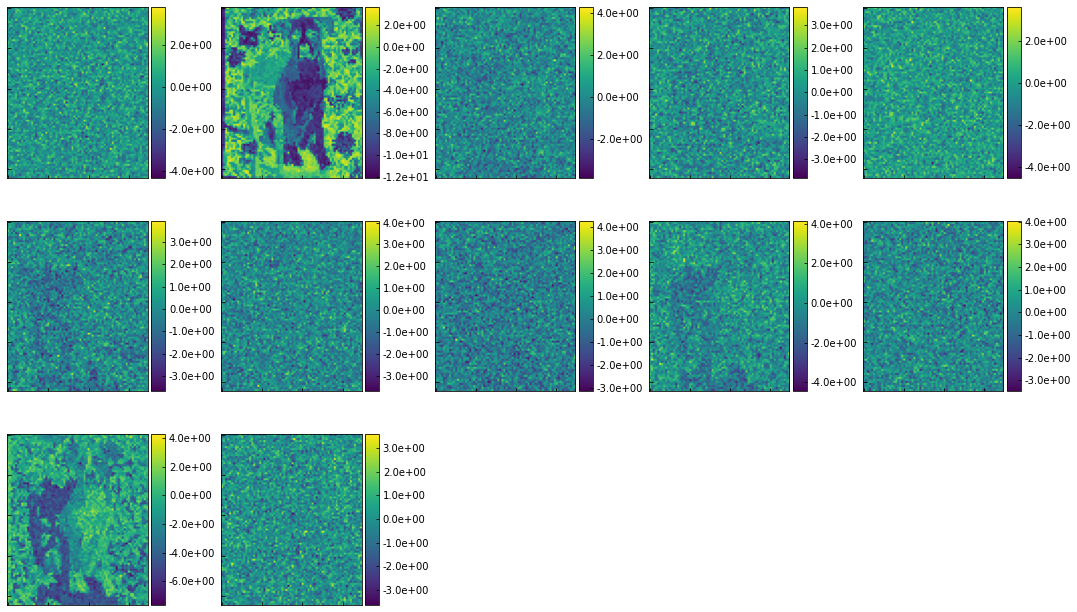

In [57]:
viz.embedding_maps(encoded_spectra, image)


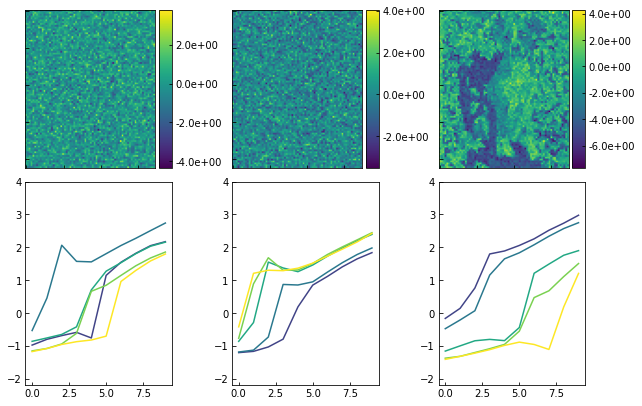

In [58]:
viz.latent_generator(decoder, encoded_spectra, image, 5, 10, indx=[0, 9, 10])


* disentanglement with $\beta$ VAE requires careful control of optimiztion. 